# Homework 6

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import skimage.segmentation
from skimage import measure
from scipy import ndimage
from sklearn.cluster import AgglomerativeClustering
from sklearn.feature_extraction.image import grid_to_graph

import warnings
warnings.filterwarnings('ignore')

# Задача №1 - Выделить береговую линию

Теперь приступим к задаче сегментации на картинках. Реализуйте программу, которая определить береговую линию, то есть разделит изображение на 2 класса: берег и вода. 

Примеры изображений:
<table><tr>
    <td> <img src="ships/0d5b831d8.jpg" alt="Drawing" style="width: 200px;"/> </td>
    <td> <img src="ships/8bb60a003.jpg" alt="Drawing" style="width: 200px;"/> </td>
    <td> <img src="ships/161dfbbdc.jpg" alt="Drawing" style="width: 200px;"/> </td>
</tr></table>

# Алгоритм
1)	Ищем кластеры `ф-ция get_map_label()`
2)	Постобработка `ф-ция clusters()`:
> Далее за цвет кластера берем середину его гистограммы (точка, делющая на 2 более менее равные по сумме части массива)   <br/>`ф-ция hist_middle()`
<br/> a.	Уберем те кластеры, которые по цвету не совпадают с представлением о море (ну оно тип зеленое или синие). 
<br/>b.	Уберем кластеры с сильным перепадом цвета относительно других кластеров (так как синий в палитре hsv идет после зеленого, а только они у нас и остались после a., то просто спускаемся от максимума из цветов и ищем, когда произошел перепад). `ф-ция get_clean_labels()`
<br/>с. Далее объединяем в одну маску, где 1-море, а 0-суша.
<br/>d. Надо почистить маску:
>> I) Чистим сушу от всяких точек (так как на картинках вода соприкасается с краями, то просто уберем все единички, которые не соприкасаются с краями картинки) `ф-ция mask_land_cleaning()`
<br/>II) Чистим море от всяких точек и лодок `ф-ция sea_cleaning()`
<br/>III) У нас могут возникнуть несколько областей моря и надо посмотреть, что там (может суша), ну и если это не море, то надо убрать `ф-ция land_cleaning()`


In [2]:
def plot_images_grid(images):
    a = int(np.sqrt(len(images)))+1
    fig, axes = plt.subplots(len(images)//a+1, a, figsize=(16, 16))
    axes = axes.ravel()

    for i, im in enumerate(images):
        axes[i].imshow(im)
        axes[i].set_title(f'im {i}')

    for ax in axes:
        ax.axis('off')

In [3]:
# Класс параметров для работы
class Parameters:
    def __init__(self, params={}):
        
        # количество класторов 
        self.n_clusters = params['n_clusters'] if 'n_clusters' in params else 11
        
        # коэффициент уменьшения картинки 
        self.k_resize = params['k_resize'] if 'k_resize' in params else 4
        
        # какого цвета море 
        self.min_h_threshold = params['min_threshold'] if 'min_threshold' in params else 33
        self.max_h_threshold = params['max_threshold'] if 'max_threshold' in params else 150
        
        # для удаления лодок
        self.min_h_threshold2 = params['min_threshold2'] if 'min_threshold2' in params else 69
        
        # Перепад цвета кластеров (b.)
        self.col_dist_threshold = params['col_dist_threshold'] if 'col_dist_threshold' in params else 22
        
        # Перепад цвета областей (III)
        self.area_col_max_dist = params['area_col_max_dist'] if 'area_col_max_dist' in params else 15
        
        # Какого размера острова могут быть (в этом случае это im.shape[0]*im.shape[1]//400)
        self.min_island_size = params['min_island_size'] if 'min_island_size' in params else 92

In [4]:
def hist_middle(hist):
    """
    Функция для поиска точки, делящую на 2 более менее равные по сумме части массива
    """
    left_sum = np.sum(hist)
    right_sum = 0
    for i, x in enumerate(hist):
        left_sum -= x
        right_sum += x
        if right_sum > left_sum:
            return i
    return len(hist)

In [5]:
def sea_cleaning(mask, hsv_im, params: Parameters):
    """
    Функция для чистки моря в маске от лодок
    """
    hist = cv2.calcHist([hsv_im[:,:,0][mask]], [0], None, [180], [0, 180])
    sea_hist_max = np.argmax(hist)
    
    map_labels = measure.label(mask == 0)
    labels = np.unique(map_labels)
    labels = labels[1:]

    res_labels = []
    for l in labels:
        hist = cv2.calcHist([hsv_im[:,:,0][map_labels == l]], [0], None, [180], [0, 180])
    
        h_hist_max = hist_middle(hist)
        if (h_hist_max > params.min_h_threshold2 and h_hist_max < params.max_h_threshold) or np.sum(hist) < params.min_island_size:
            res_labels.append(l)

    new_mask = mask.copy()
    for l in res_labels:
        new_mask |= map_labels == l
    return new_mask

In [6]:
def land_cleaning(mask, hsv_im, params: Parameters):
    """
    Функция для чистки моря в маске от лишних областей 
    """
    map_labels = measure.label(mask)
    labels = np.unique(map_labels)
    labels = labels[1:]
    hists_middle = []
    for l in labels:
        hist = cv2.calcHist([hsv_im[:,:,0][map_labels == l]], [0], None, [180], [0, 180])
        hists_middle.append(hist_middle(hist))
    
    if not hists_middle:
      return mask.copy() 

    hists_middle = np.array(hists_middle)
    res_labels = labels[hists_middle > hists_middle.max() - params.area_col_max_dist]
    new_mask = np.zeros_like(mask)
    for l in res_labels:
        new_mask |= map_labels == l
    return new_mask

In [7]:
def mask_land_cleaning(mask):
    """
    Функция для чистки суши в маске от точек
    """
    new_mask = ndimage.binary_fill_holes(mask < 1)
    new_mask = new_mask == 0
    return new_mask

In [8]:
def draw_contours(see_mask, image):
    """
    Функция для отрисовки результата
    """
    
    plt.figure(figsize=(6.4*2, 4.8*2), constrained_layout=False)
    plt.imshow(image, cmap=plt.cm.gray)
    cmap = plt.cm.get_cmap('Spectral', 3)

    plt.contour(see_mask, contours=1,
                       colors=[cmap(1)])
    plt.xticks(())
    plt.yticks(())
    plt.show()

In [9]:
def draw_im(image):
    """
    Функция для отрисовки картинки
    """
    
    plt.figure(figsize=(6.4*2, 4.8*2), constrained_layout=False)
    plt.imshow(image, cmap=plt.cm.gray)
    plt.xticks(())
    plt.yticks(())
    plt.show()

In [10]:
def get_map_label(image, n_clusters):
    """
    Функция для нахождения кластеров 
    """
    
    connectivity = grid_to_graph(*image.shape)
    X = np.reshape(image, (-1, 1))
    ward = AgglomerativeClustering(n_clusters=n_clusters,
                                       linkage='ward', connectivity=connectivity, distance_threshold=None).fit(X)
    return np.reshape(ward.labels_, image.shape)[:,:,0]

In [11]:
def get_clean_labels(res_labels, hists_max, params: Parameters):
    """
    Функция для чистки лишних кластеров
    """
    
    inds = np.argsort(hists_max)[::-1]
    temp_labels = np.array(res_labels)[inds]
    temp_maxs = np.array(hists_max)[inds]
    
    imax = temp_maxs[0]
    for i in range(1, len(temp_maxs)):
        if temp_maxs[i] < imax-params.col_dist_threshold:
            return temp_labels[:i].tolist()
        imax = temp_maxs[i]

    return temp_labels.tolist()

In [12]:
def clusters(images, params: Parameters, counter=0):
    """
    Основная функция
    """
    
    if type(images) != list:
        ims = [images.copy()]
    else:
        ims = [im.copy() for im in images]
    
    for i_im, im in enumerate(ims):
        print('___________________________')
        print('image:', counter+i_im)

        hsv_im = cv2.cvtColor(im, cv2.COLOR_RGB2HSV)
        im = skimage.transform.resize(im, tuple(map(int, np.array(im.shape[:2])/params.k_resize)))
        hsv_im = cv2.resize(hsv_im.copy(), tuple(map(int, np.array(hsv_im.shape[:2])/params.k_resize)))

        label = get_map_label(im, params.n_clusters)
        
        res_labels = []
        middle_hists = []
        for l in range(np.unique(label).size):
            hist = cv2.calcHist([hsv_im[:,:,0][label == l]], [0], None, [180], [0, 180])
            middle_hist = hist_middle(hist)
            
            if middle_hist > params.min_h_threshold and middle_hist < params.max_h_threshold:
                res_labels.append(l)
                middle_hists.append(middle_hist)
#             else:
#                 print('-', middle_hist)
#         for ddd in middle_hists:
#             print('+', ddd)
        
        if not res_labels:
            draw_im(im)
            continue
        
        res_labels = get_clean_labels(res_labels, middle_hists, params)
        see_label = np.zeros(label.shape, dtype = bool)
        for l in res_labels:
            see_label |= label == l
        
        see_label = mask_land_cleaning(see_label)
        see_label = sea_cleaning(see_label, hsv_im, params)
        see_label = land_cleaning(see_label, hsv_im, params)         
        draw_contours(see_label, im)

In [13]:
def get_images(path='./ships'):
    """
    Функция, достающяя изображения  
    """
    
    images = []
    for path_im in os.listdir(path):
        images.append(cv2.imread(path+'/'+path_im))
        images[-1] = cv2.cvtColor(images[-1], cv2.COLOR_BGR2RGB)
    return images

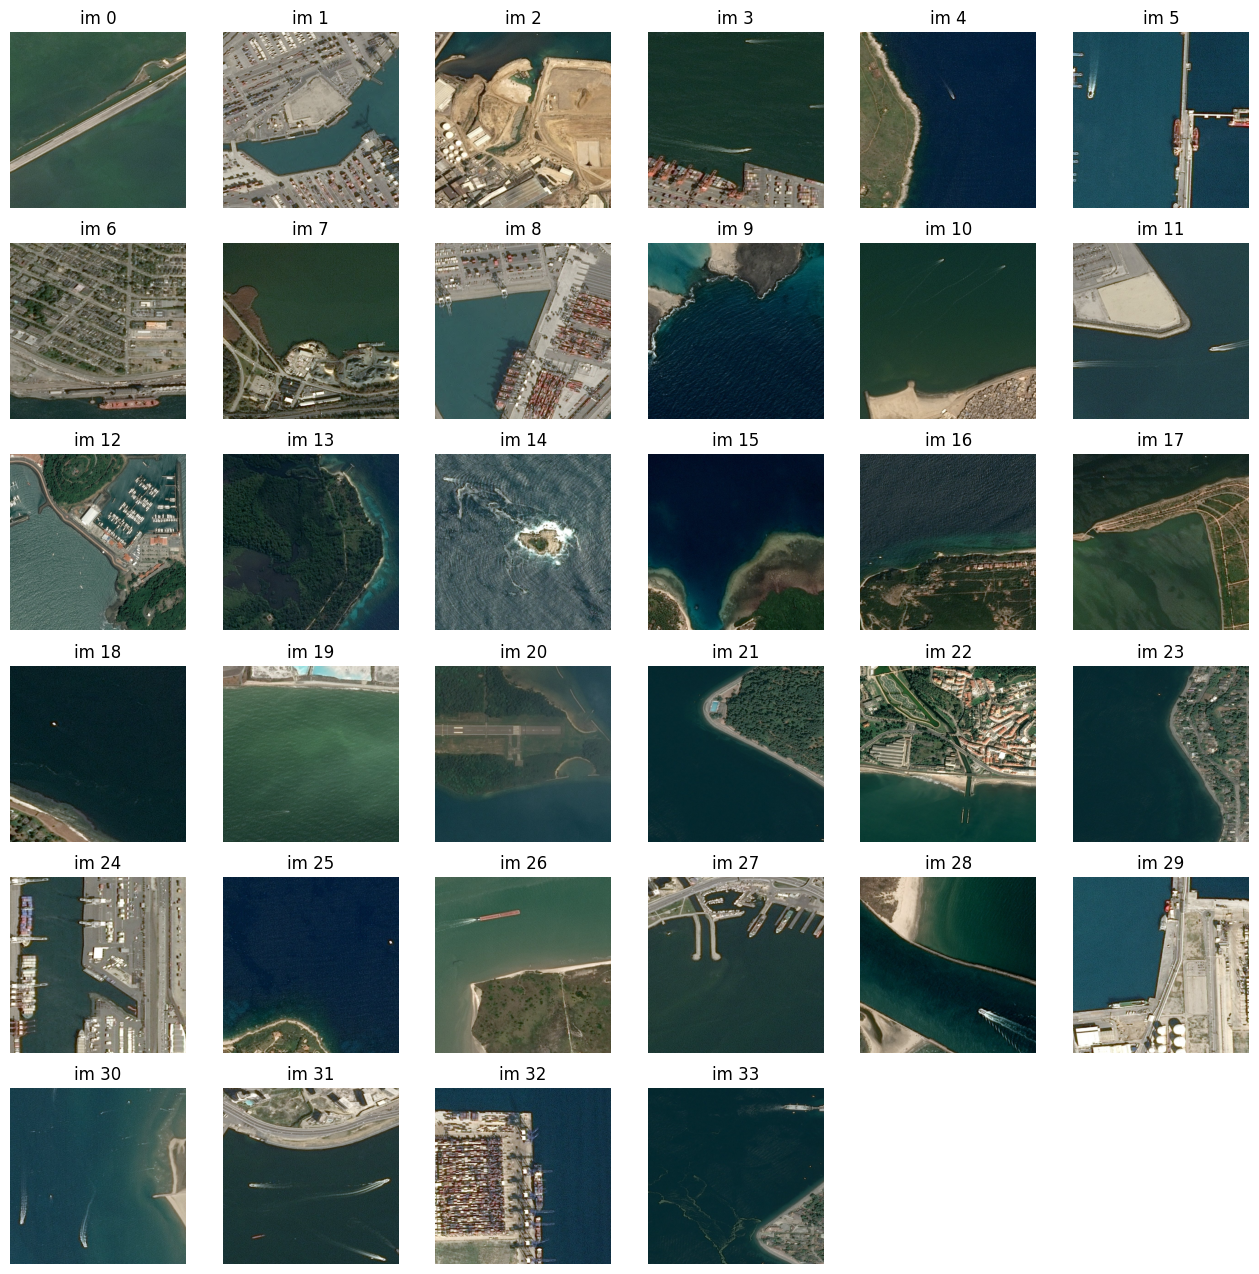

In [14]:
images = get_images()
plot_images_grid(images)

### Тут получилось что-то хорошее 

___________________________
image: 0


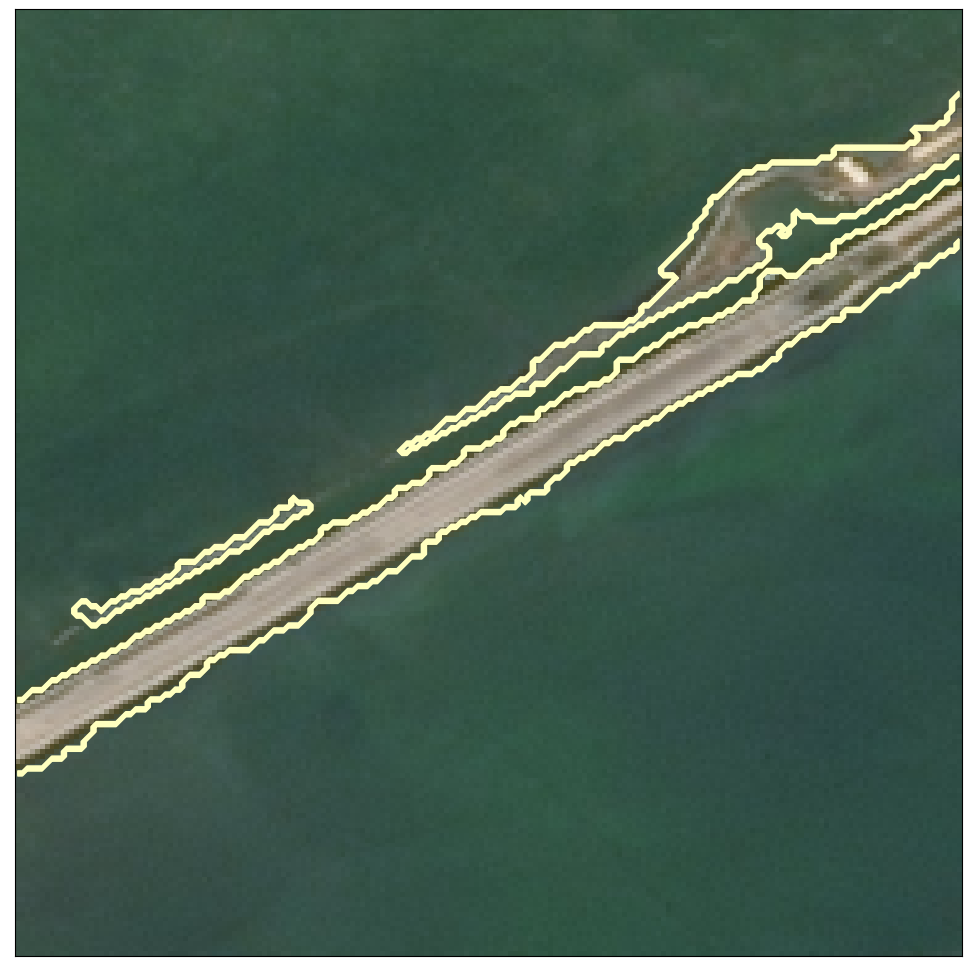

___________________________
image: 1


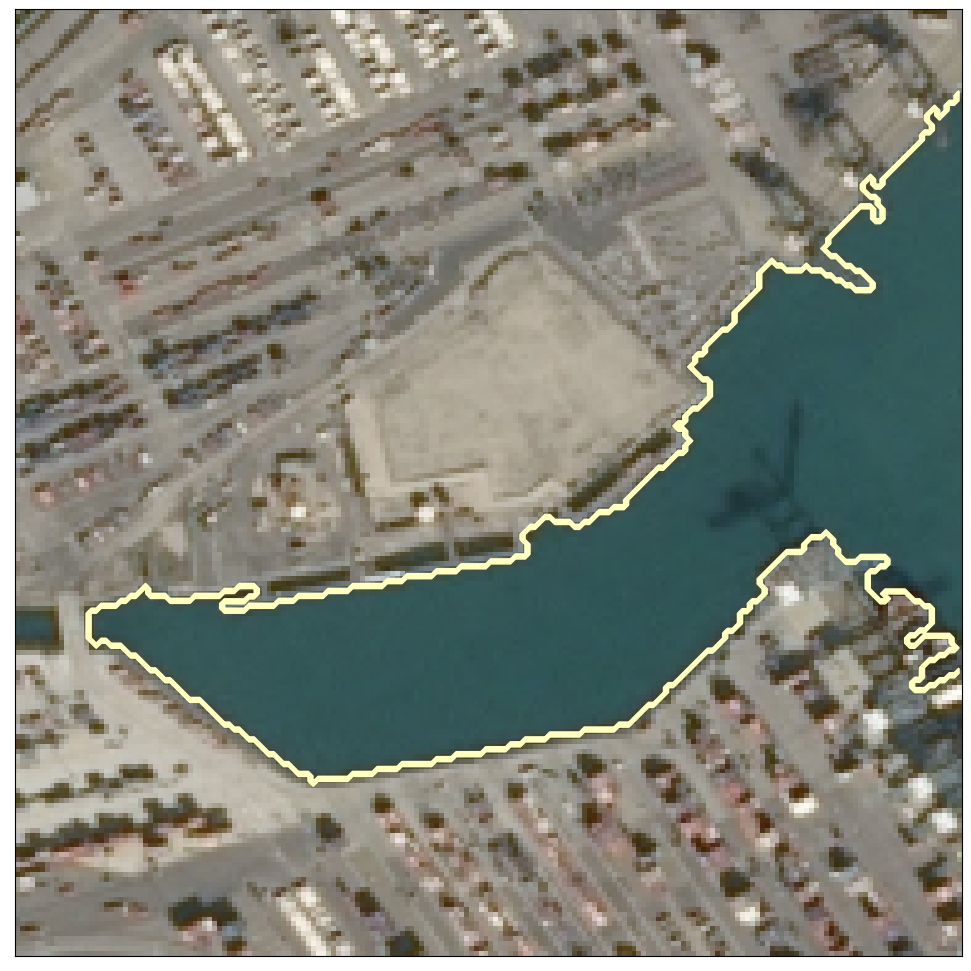

___________________________
image: 2


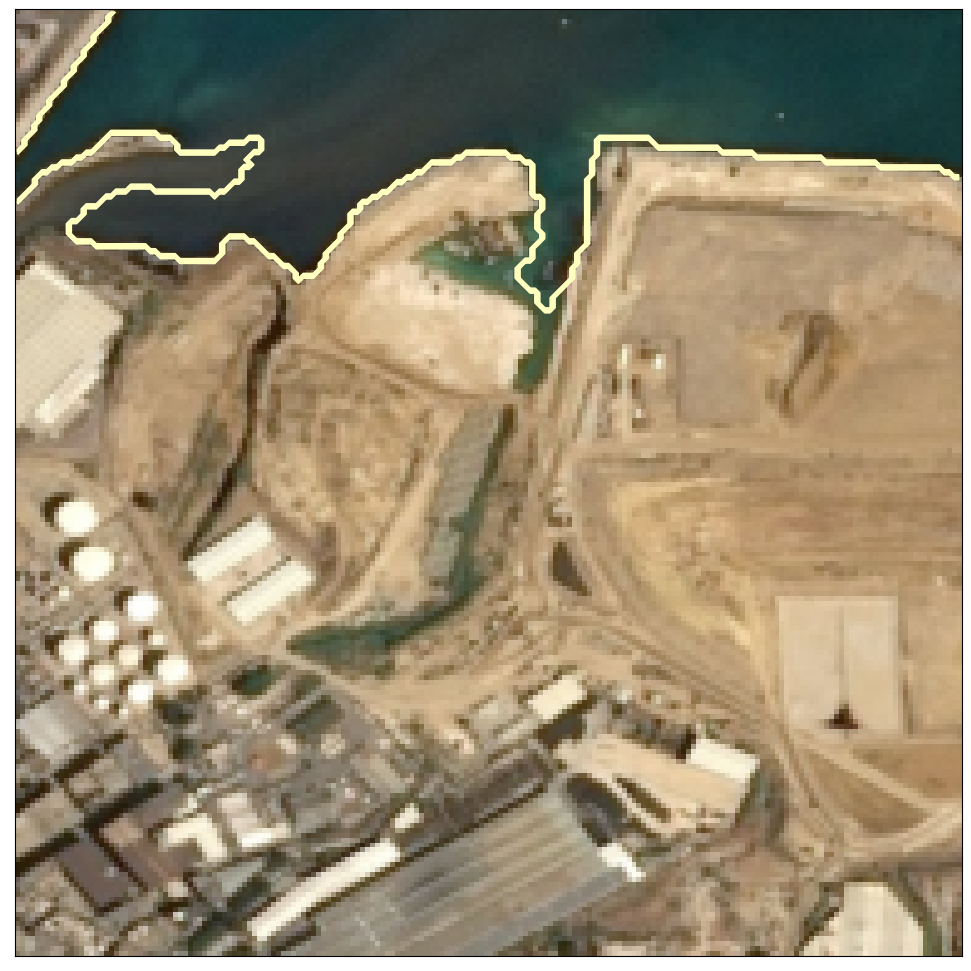

___________________________
image: 3


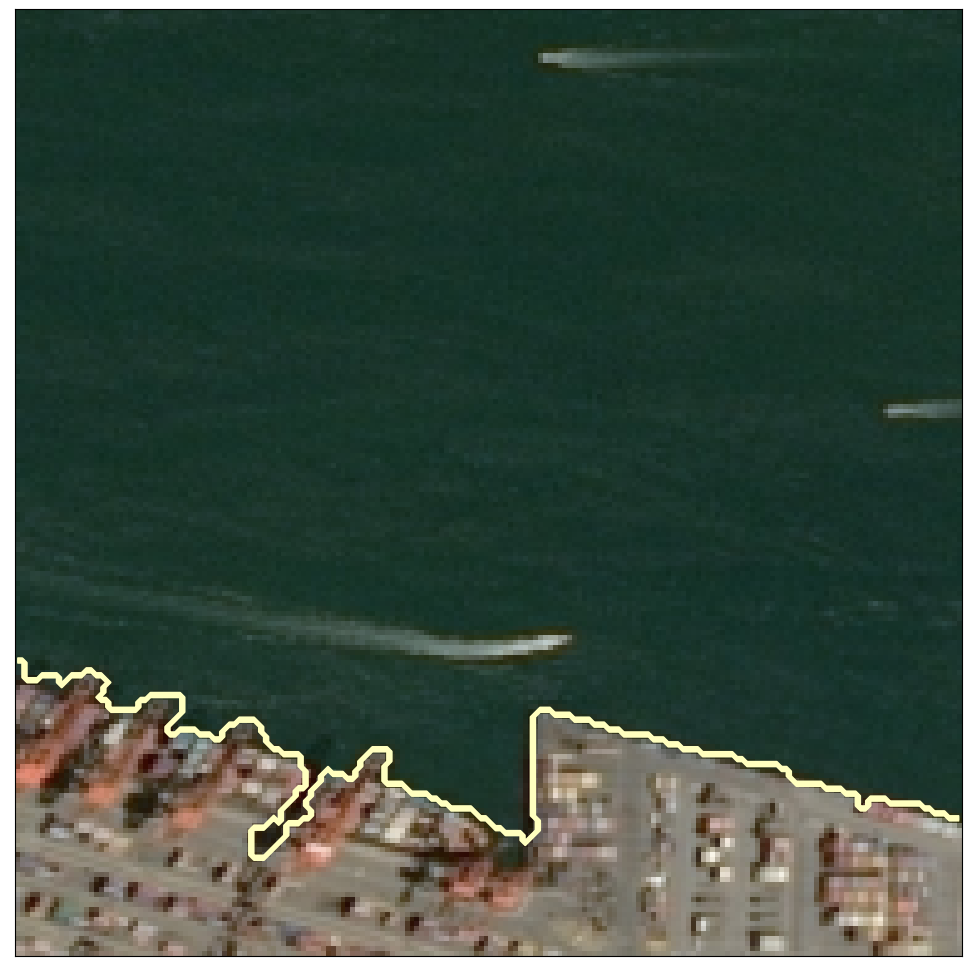

___________________________
image: 4


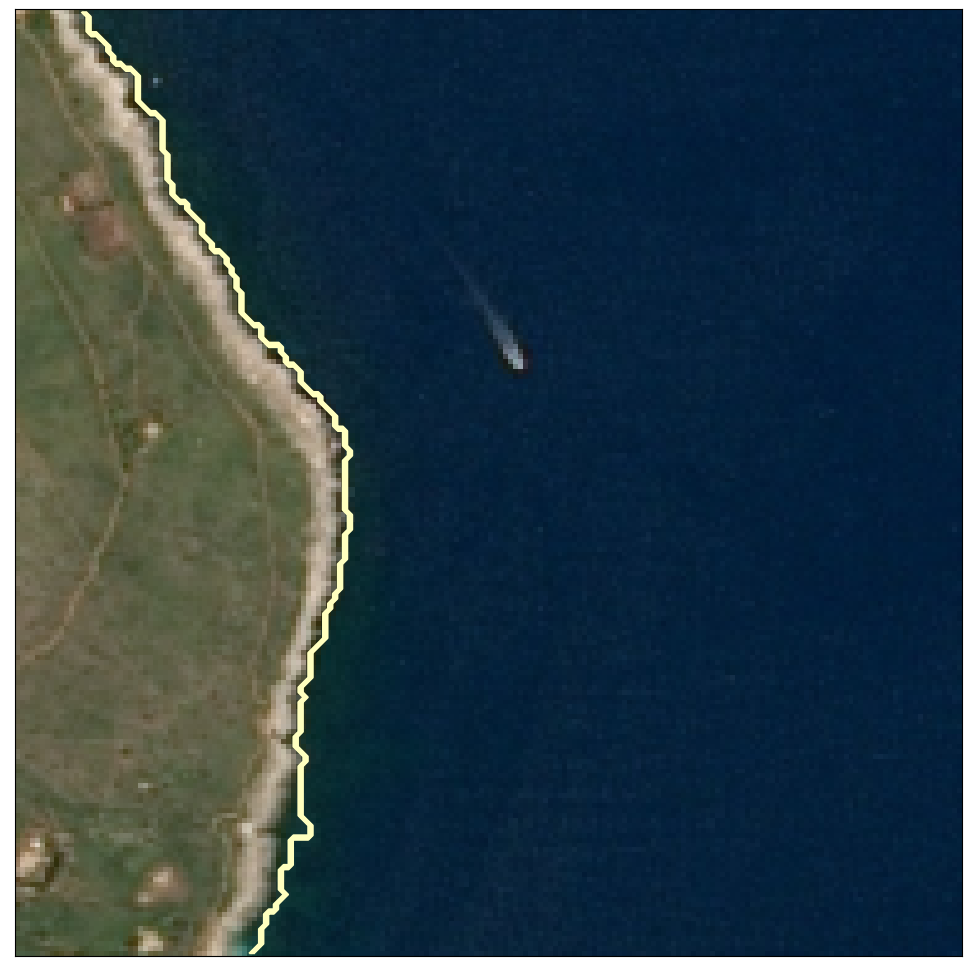

___________________________
image: 5


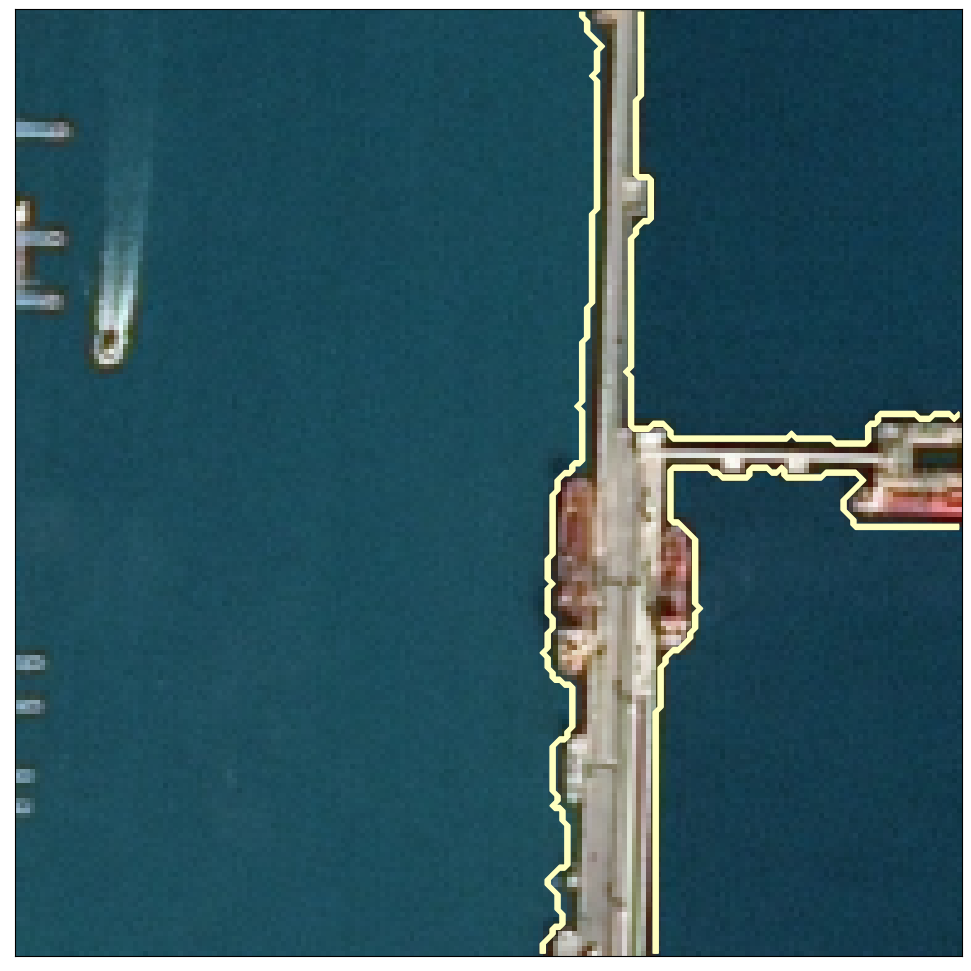

___________________________
image: 6


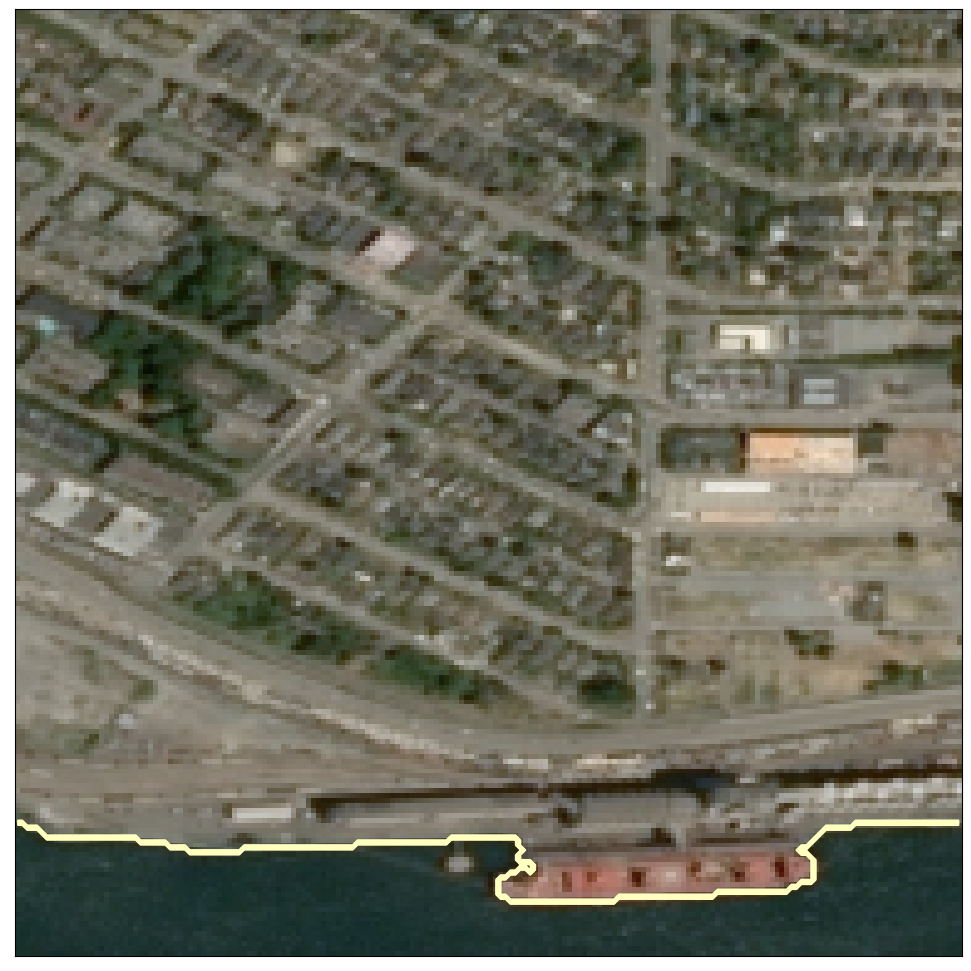

___________________________
image: 7


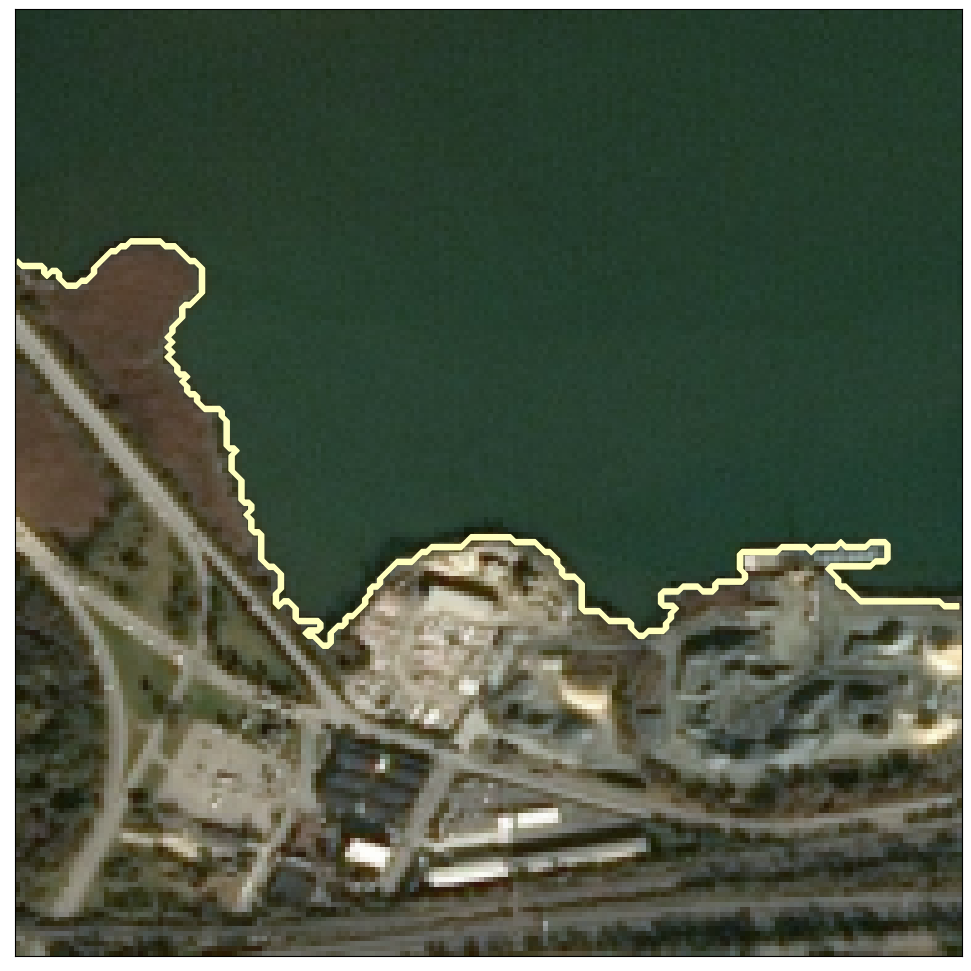

___________________________
image: 8


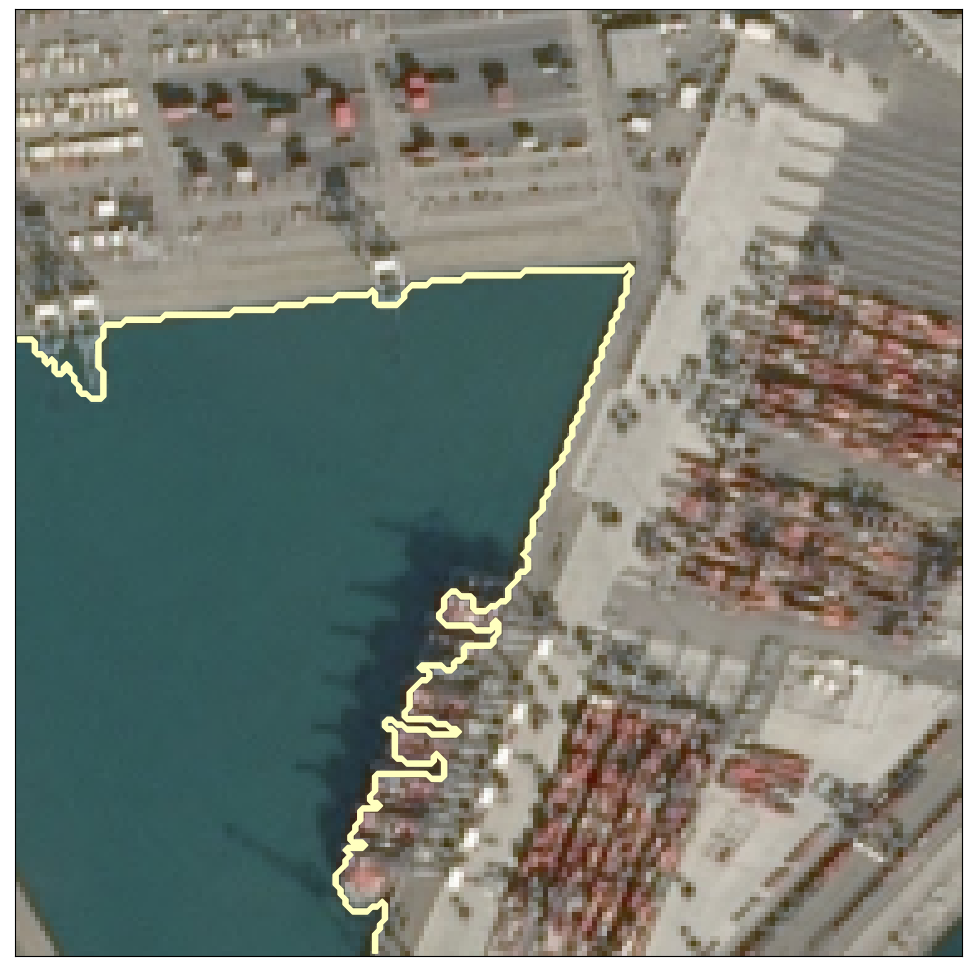

___________________________
image: 10


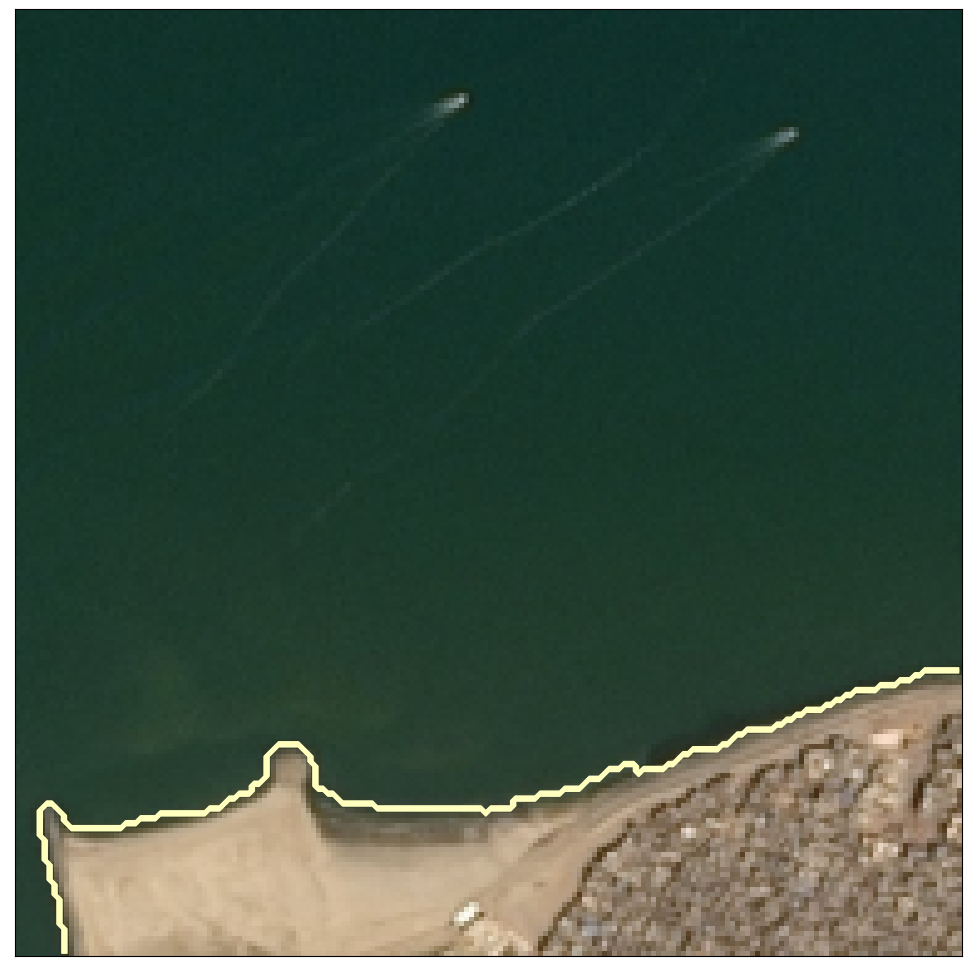

___________________________
image: 11


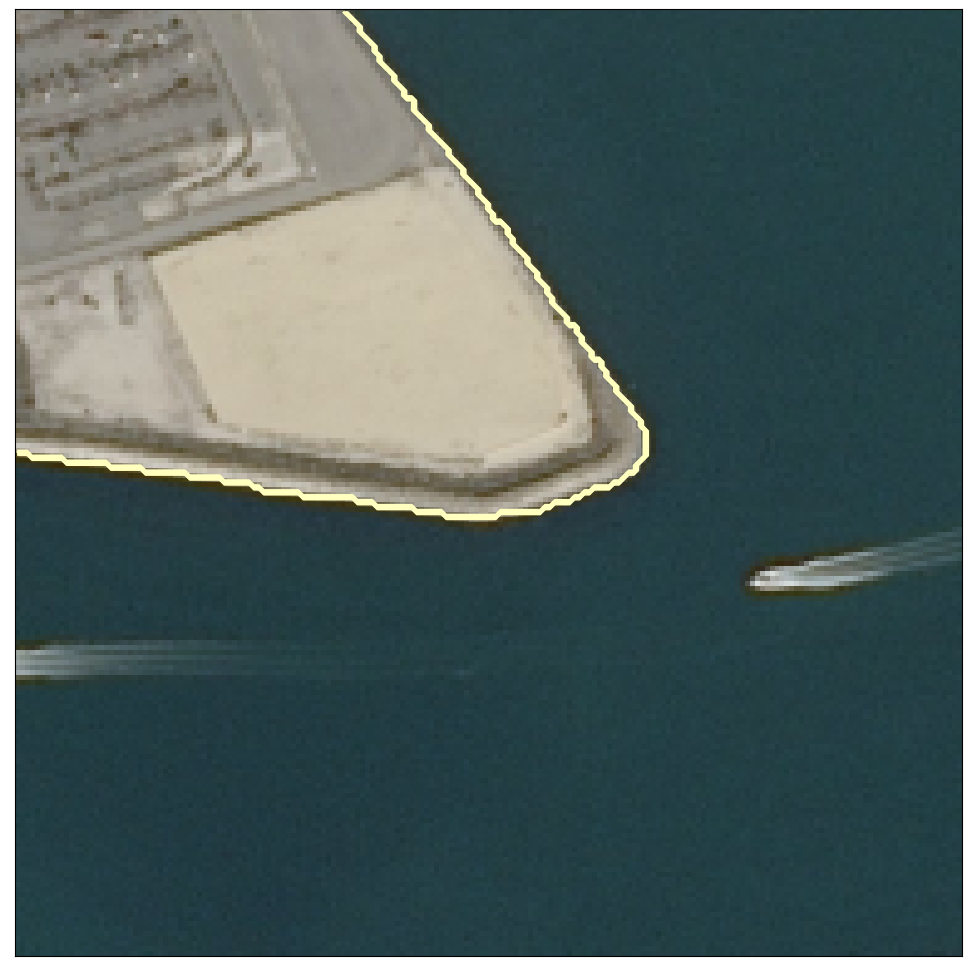

___________________________
image: 15


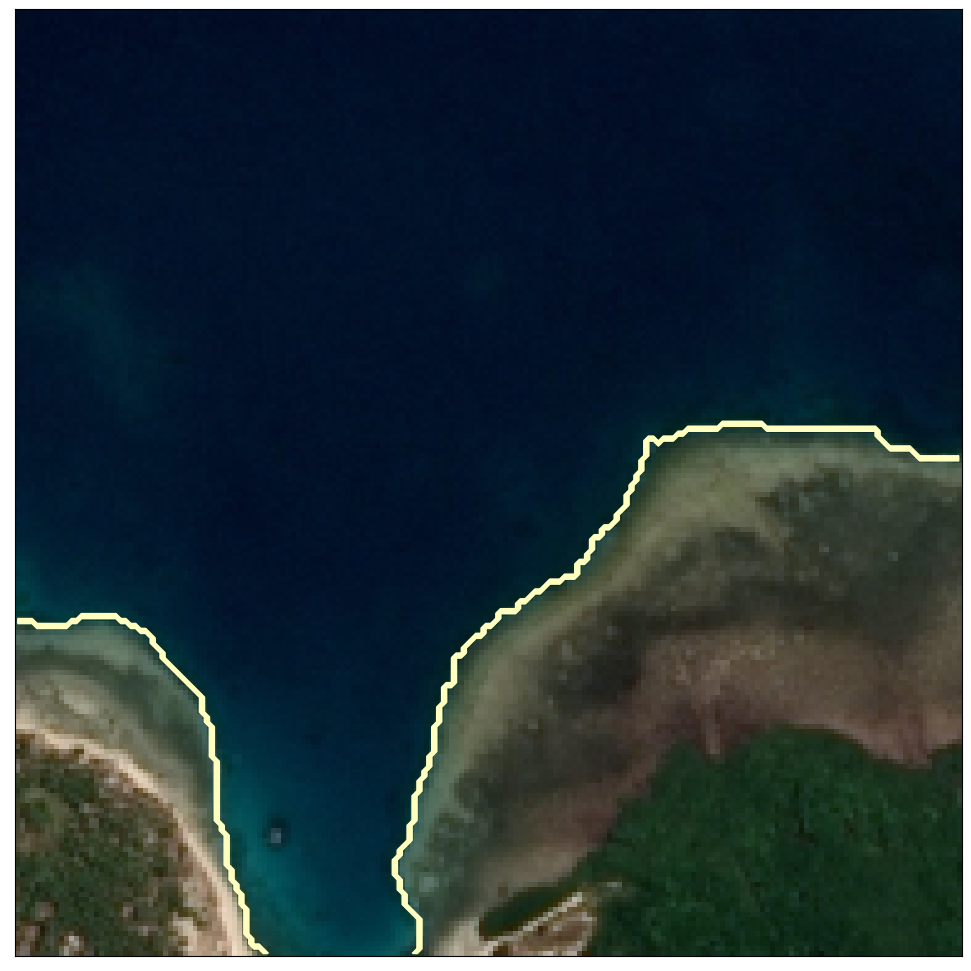

___________________________
image: 18


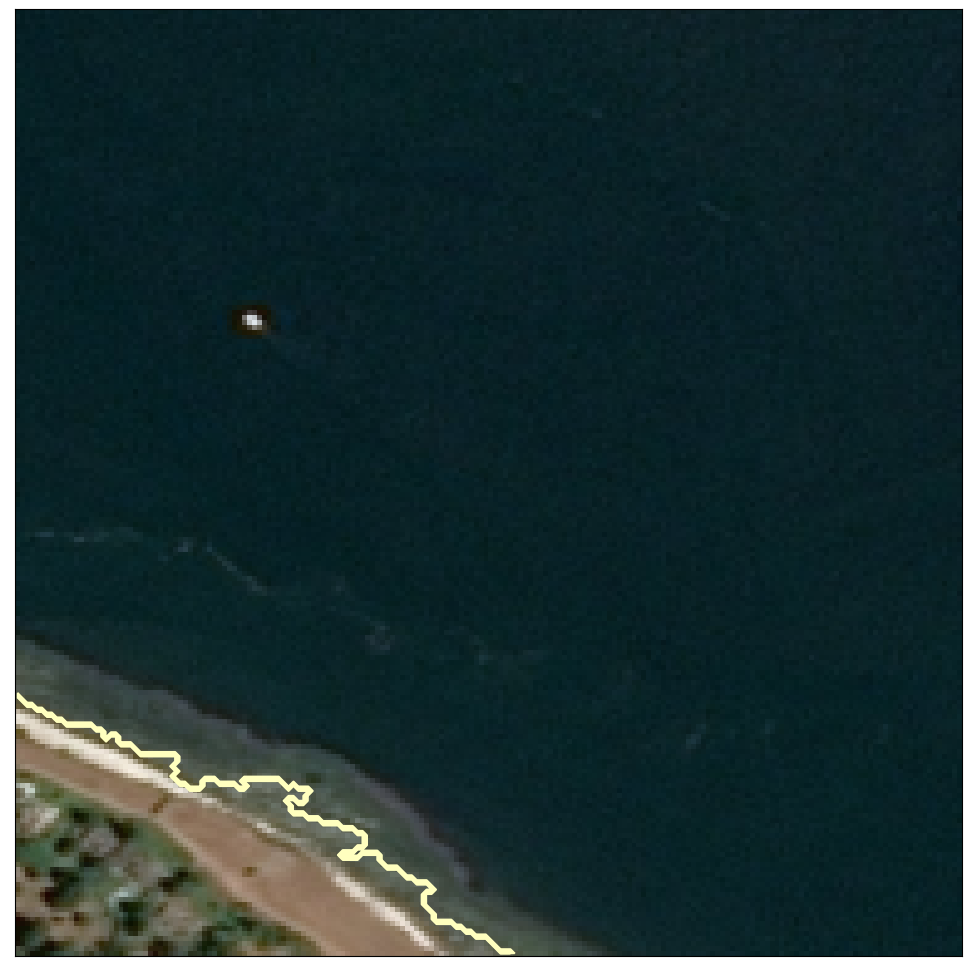

___________________________
image: 19


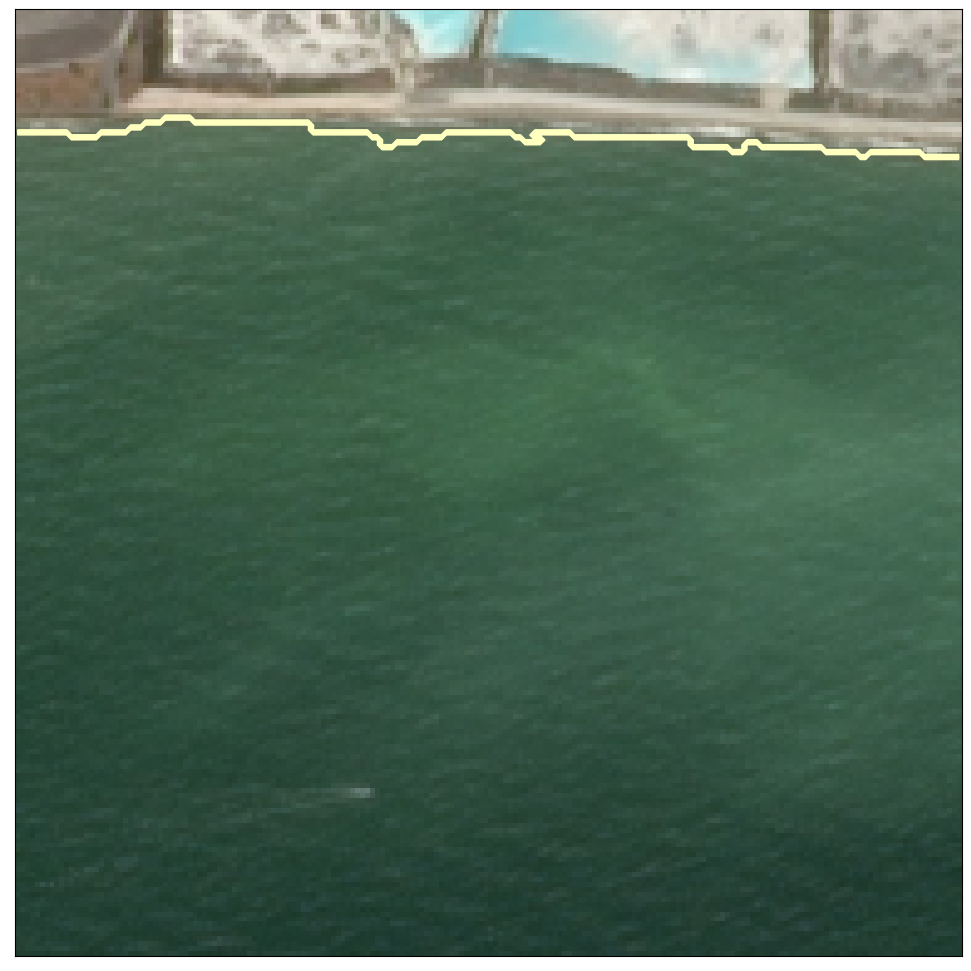

___________________________
image: 22


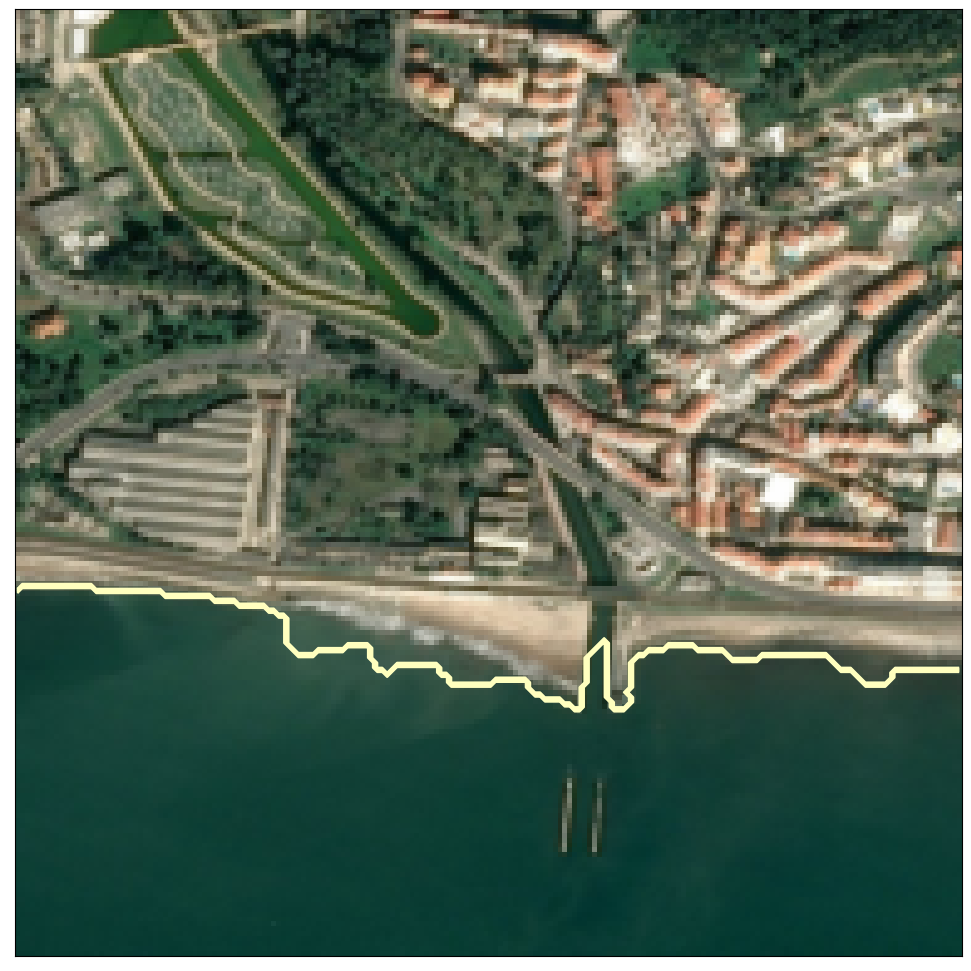

___________________________
image: 23


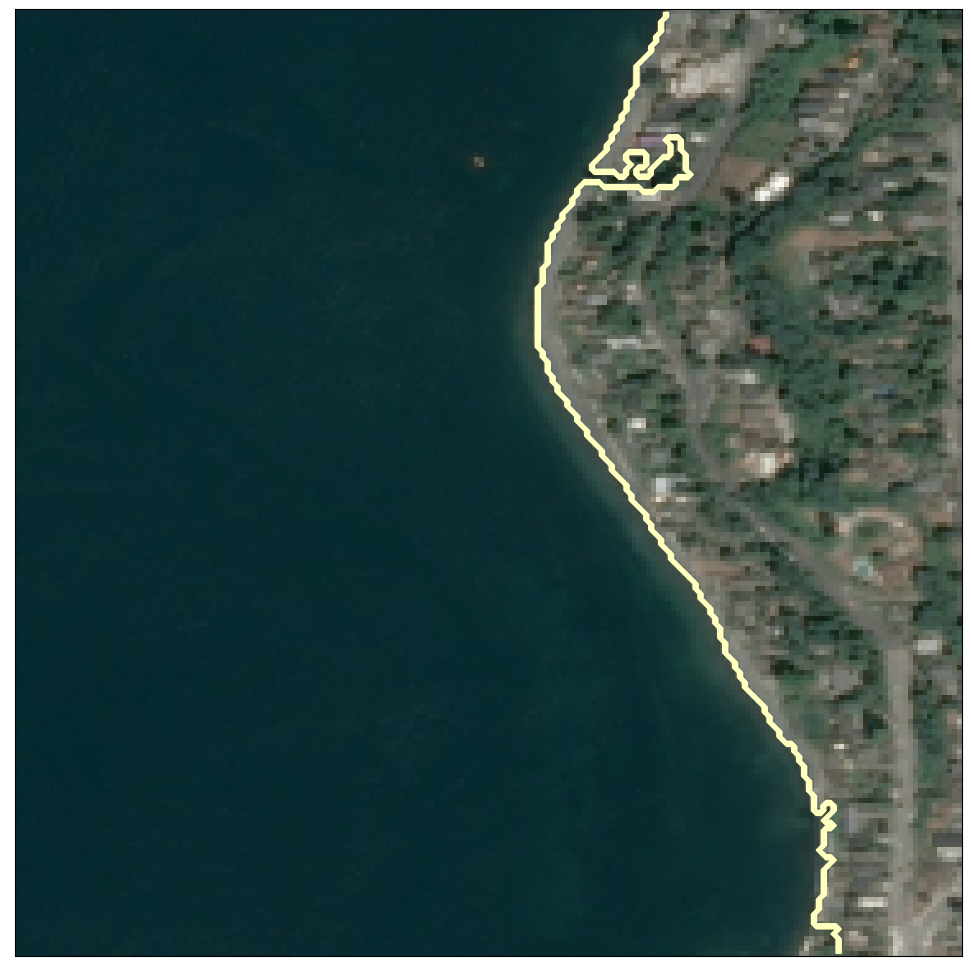

___________________________
image: 24


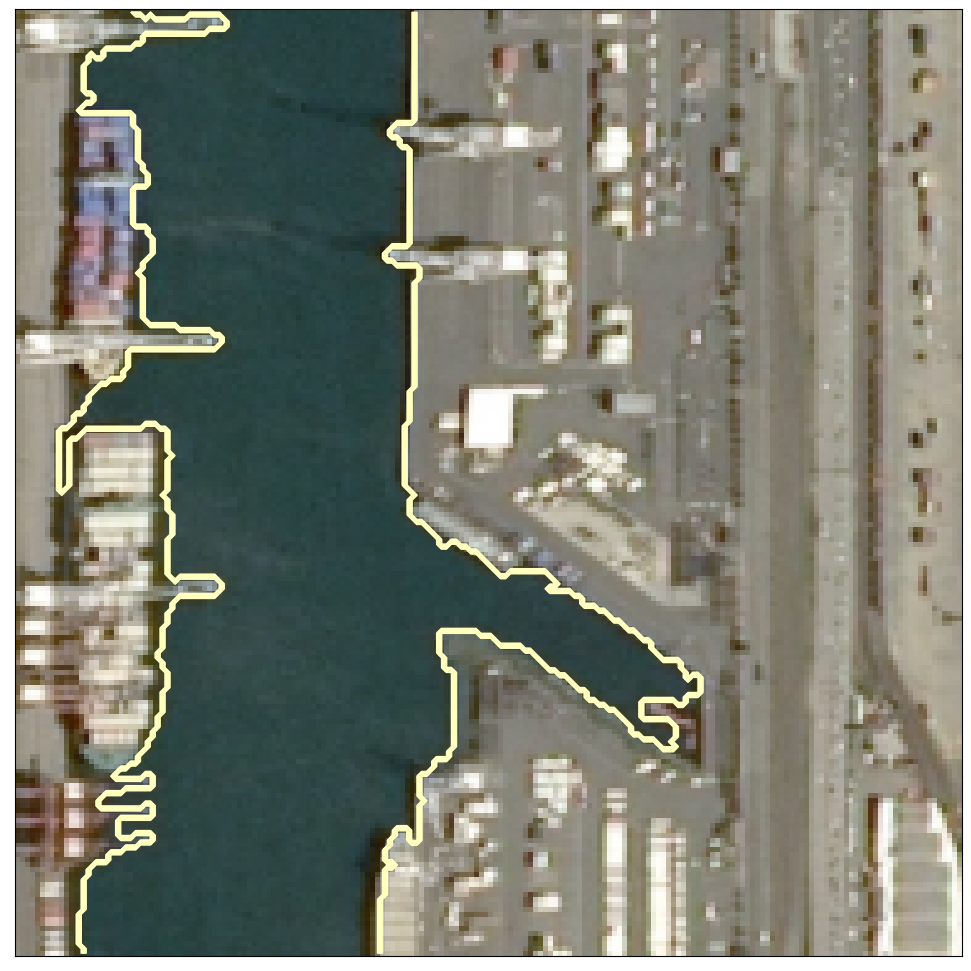

___________________________
image: 25


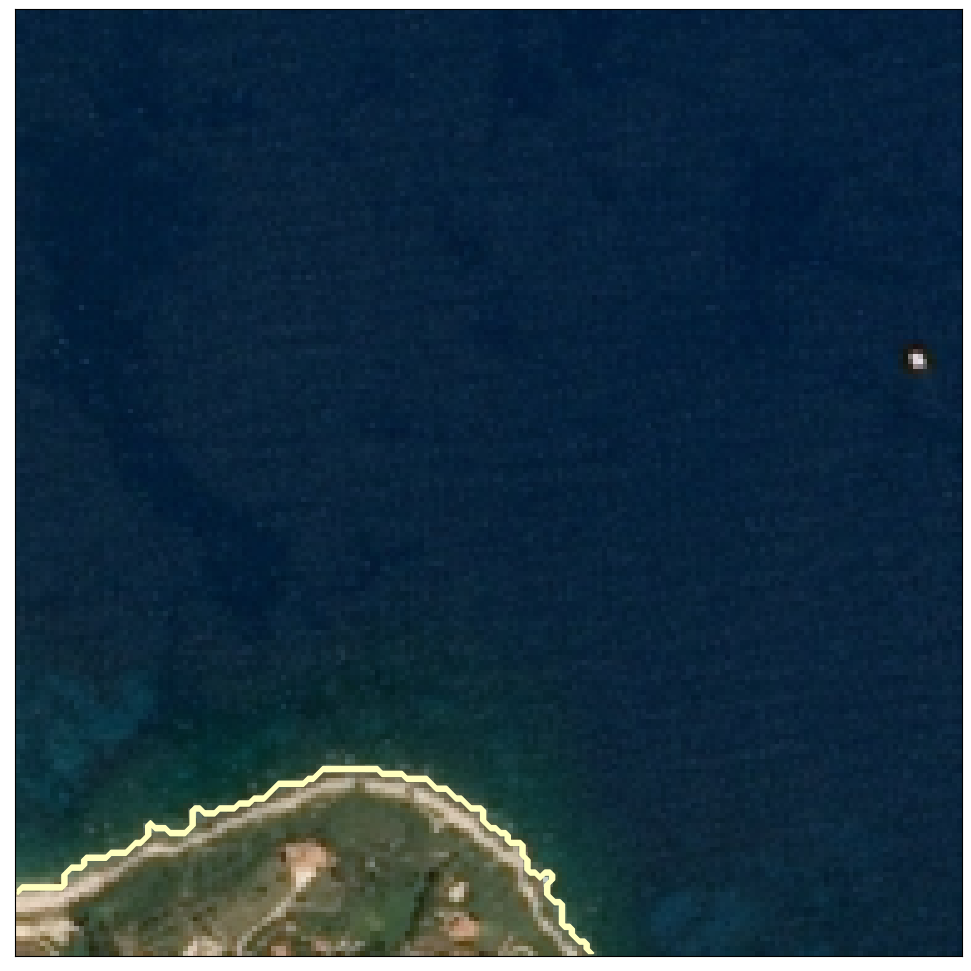

___________________________
image: 26


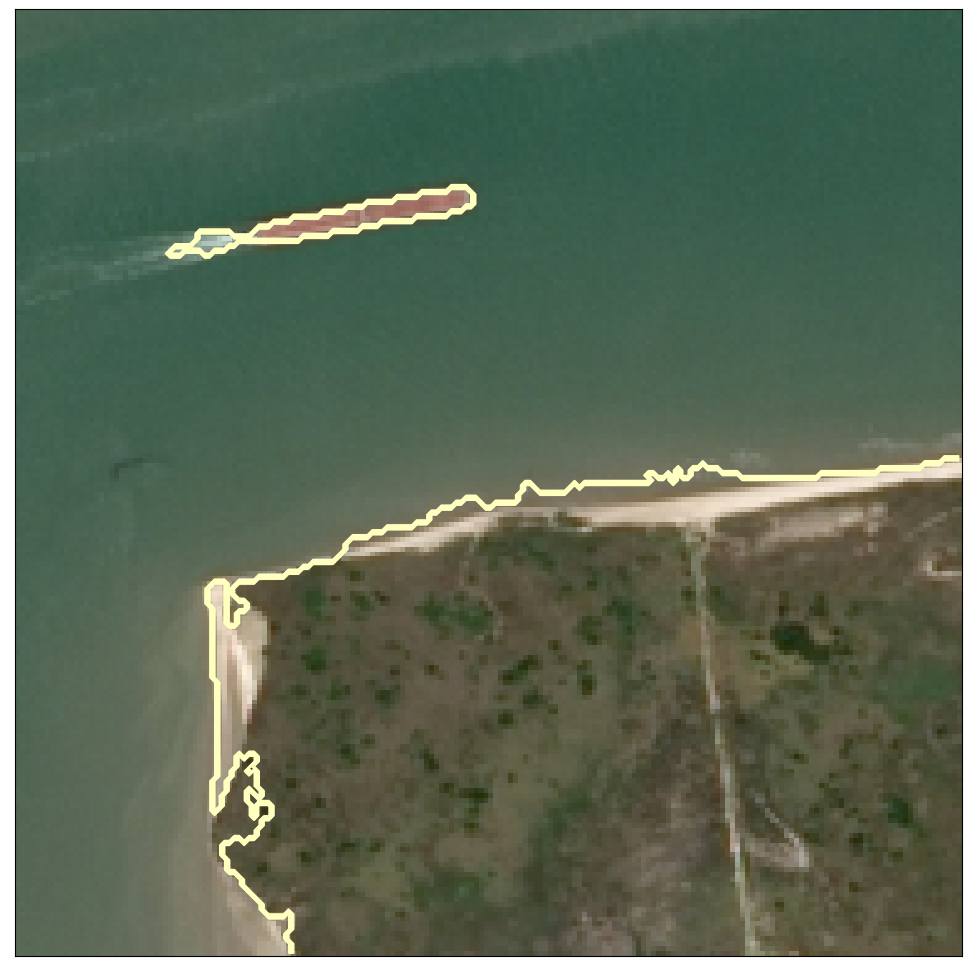

___________________________
image: 27


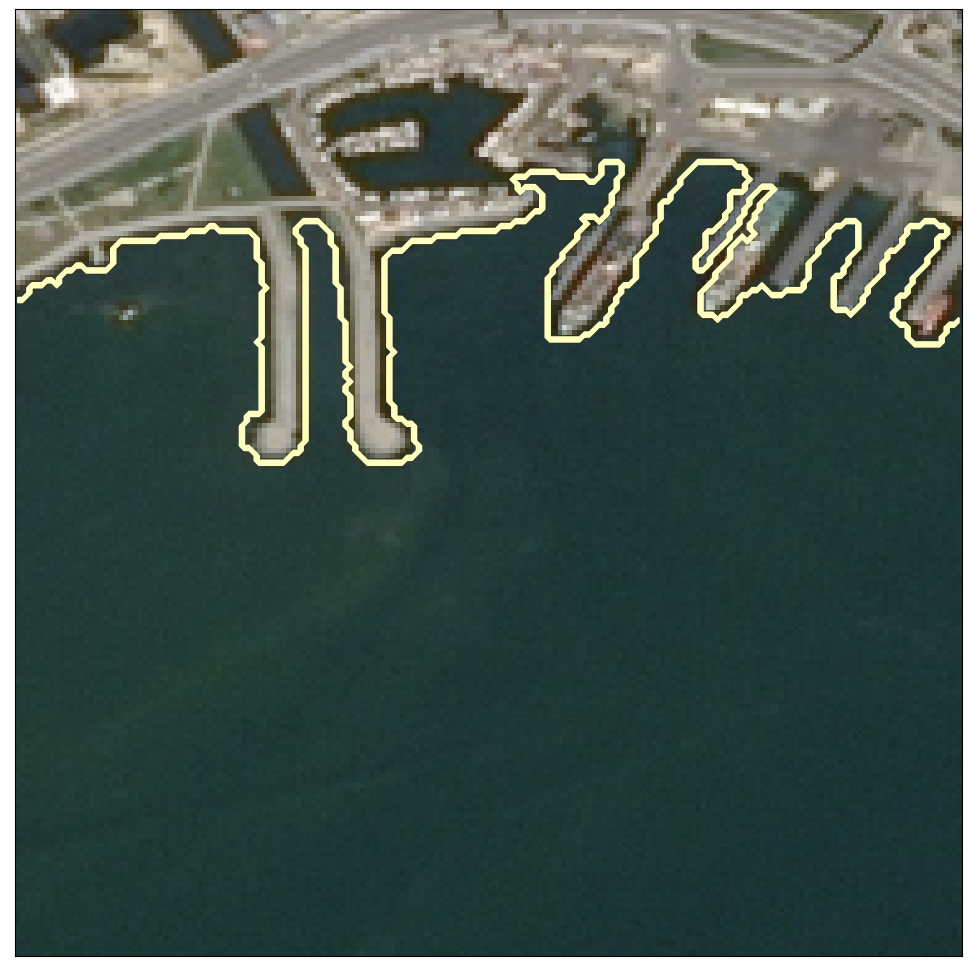

___________________________
image: 29


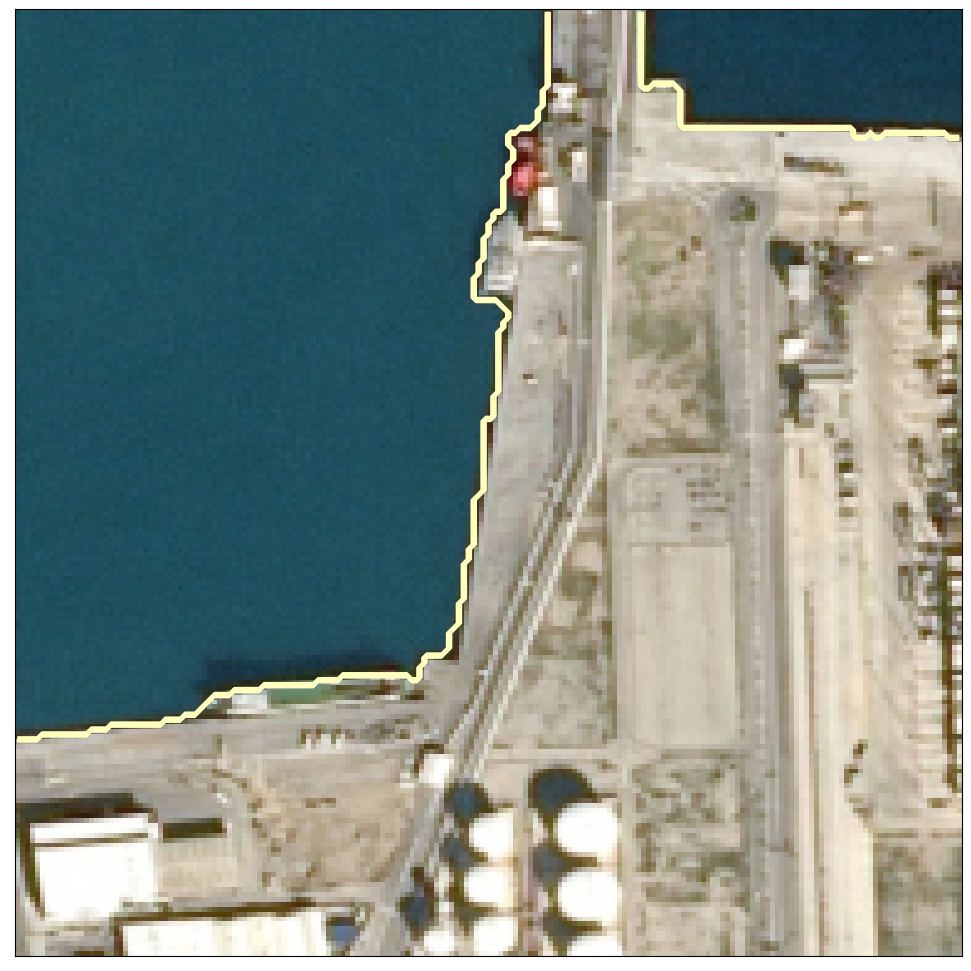

___________________________
image: 31


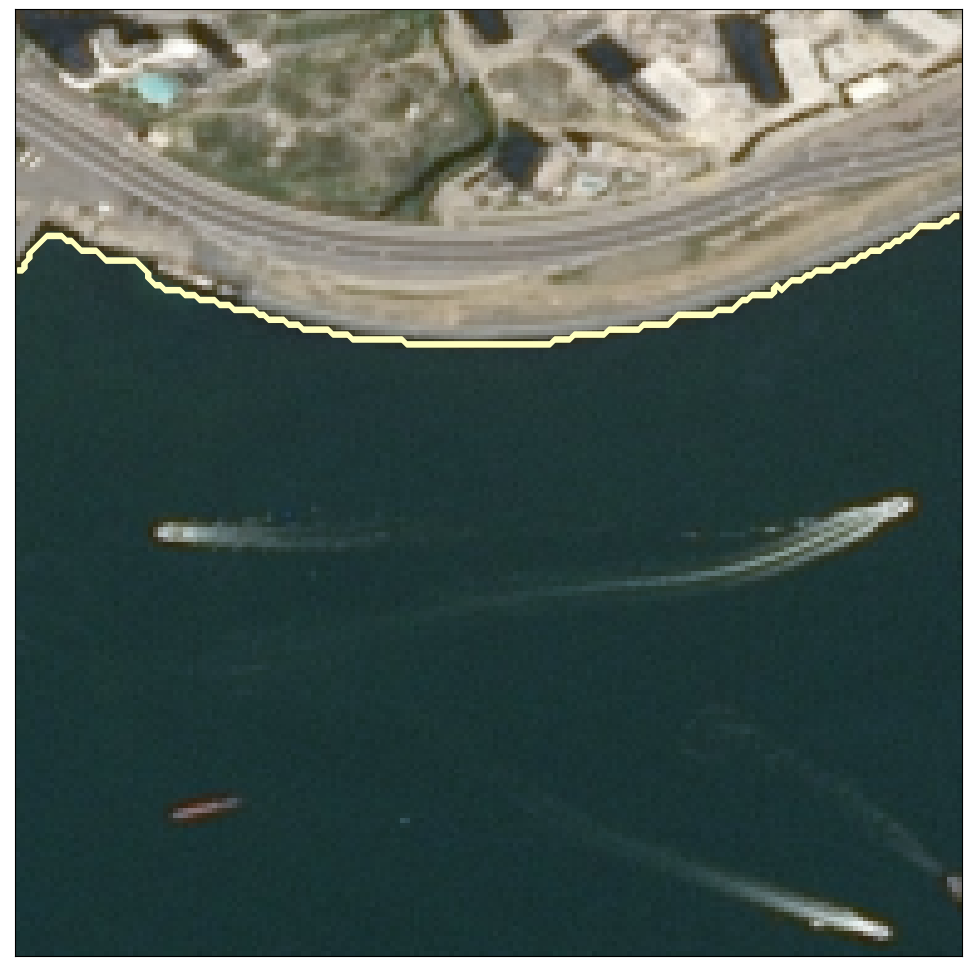

___________________________
image: 32


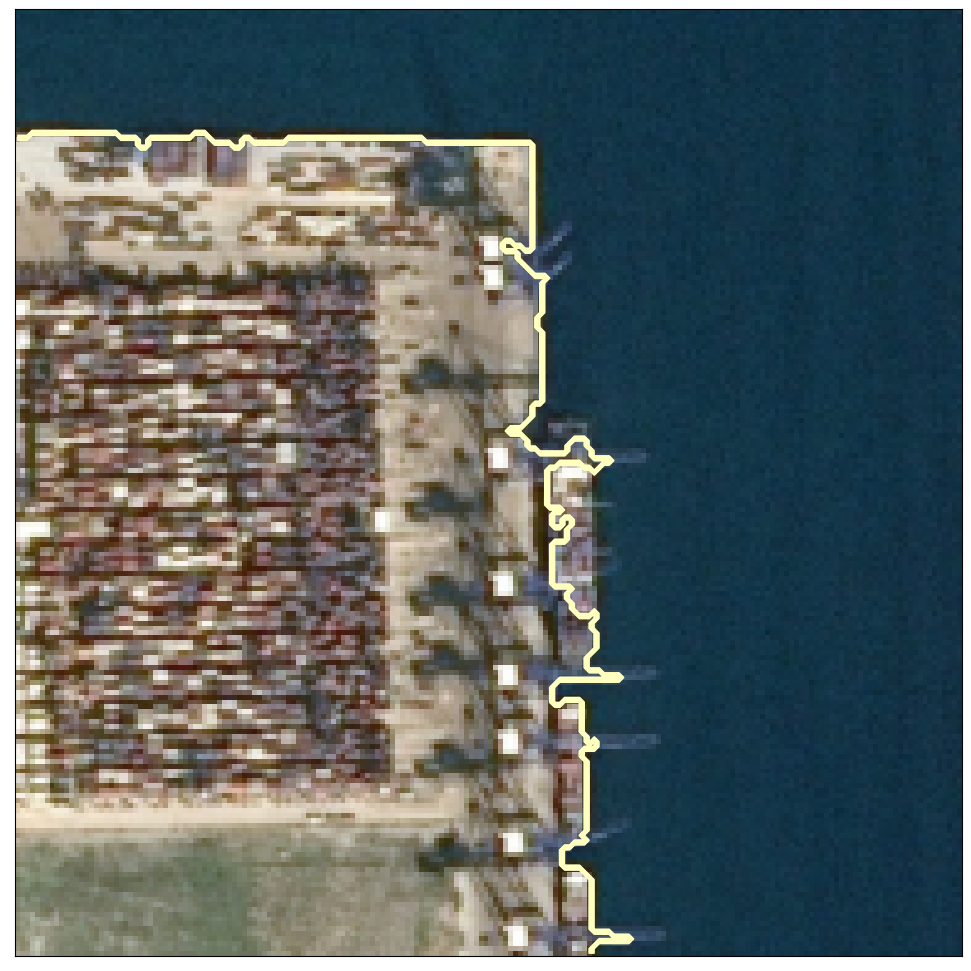

In [15]:
clusters(images[:9], Parameters(), counter=0) 
clusters(images[10:12], Parameters(), counter=10)
clusters(images[15], Parameters(), counter=15)
clusters(images[18:20], Parameters(), counter=18)
clusters(images[22:28], Parameters(), counter=22)
clusters(images[29], Parameters(), counter=29)
clusters(images[31:33], Parameters(), counter=31)

### Тут я подгонял параметры

___________________________
image: 9


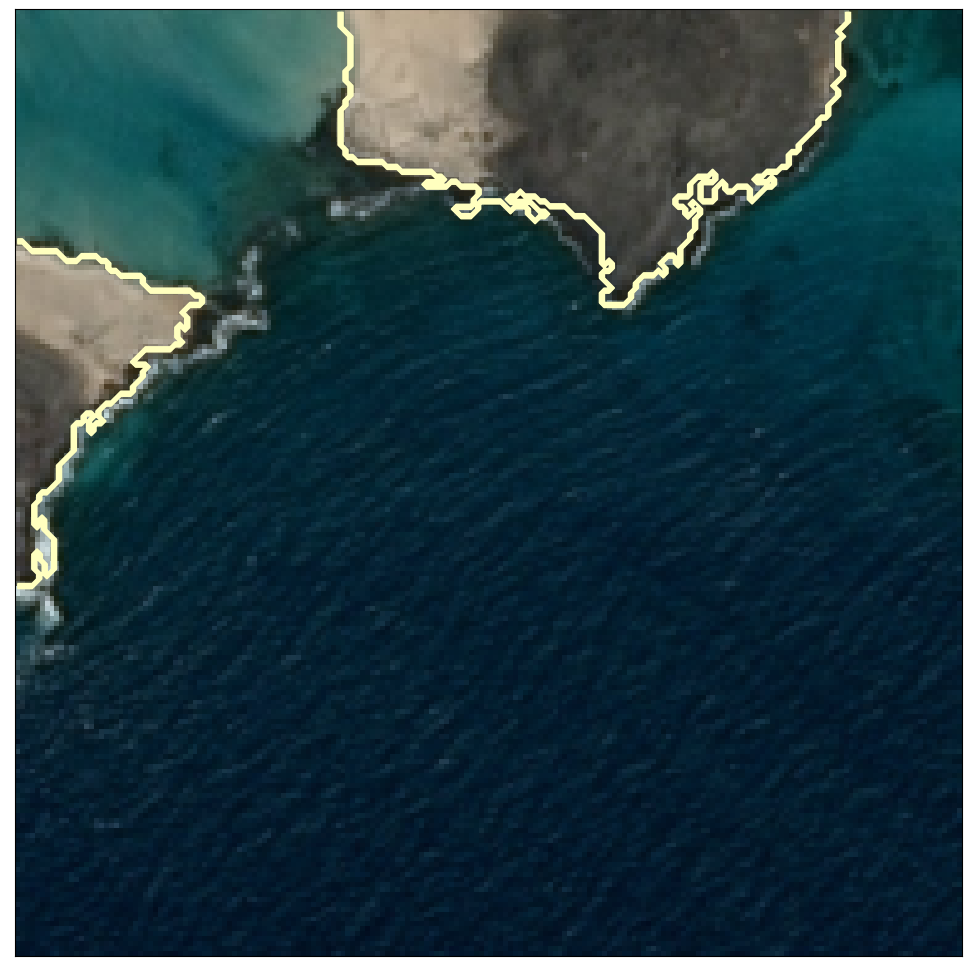

___________________________
image: 12


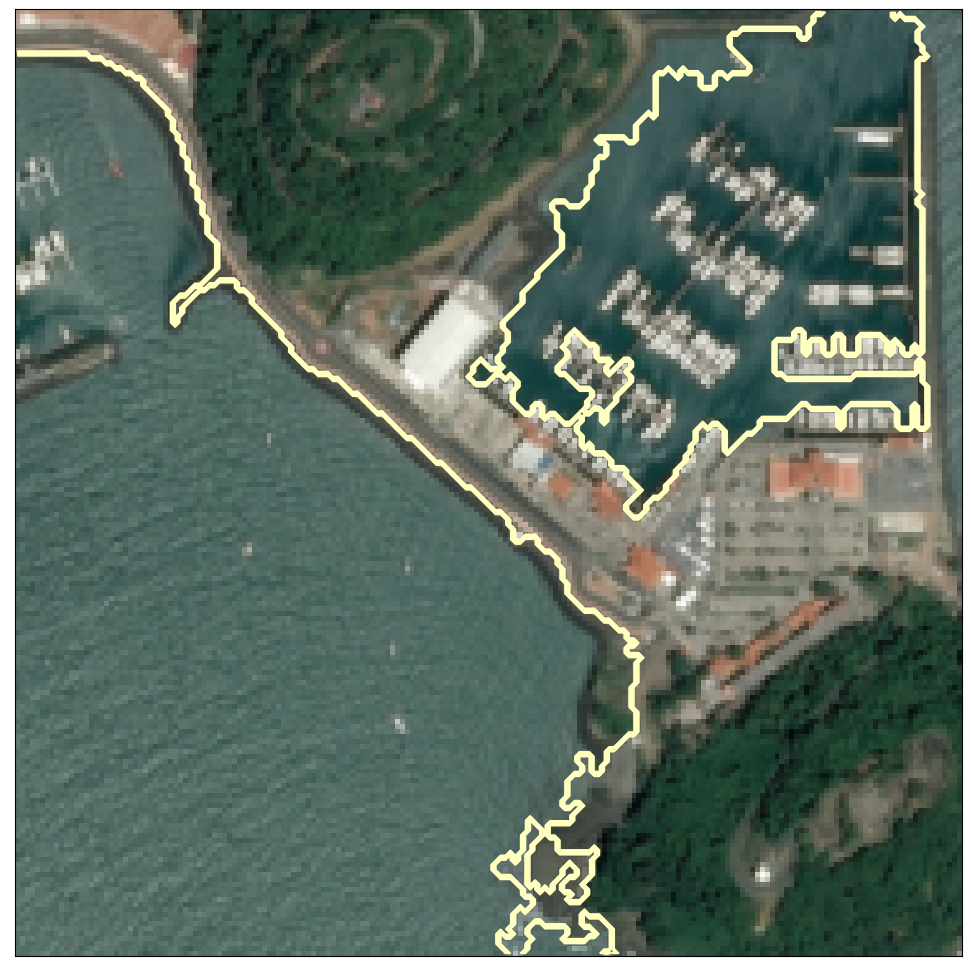

___________________________
image: 16


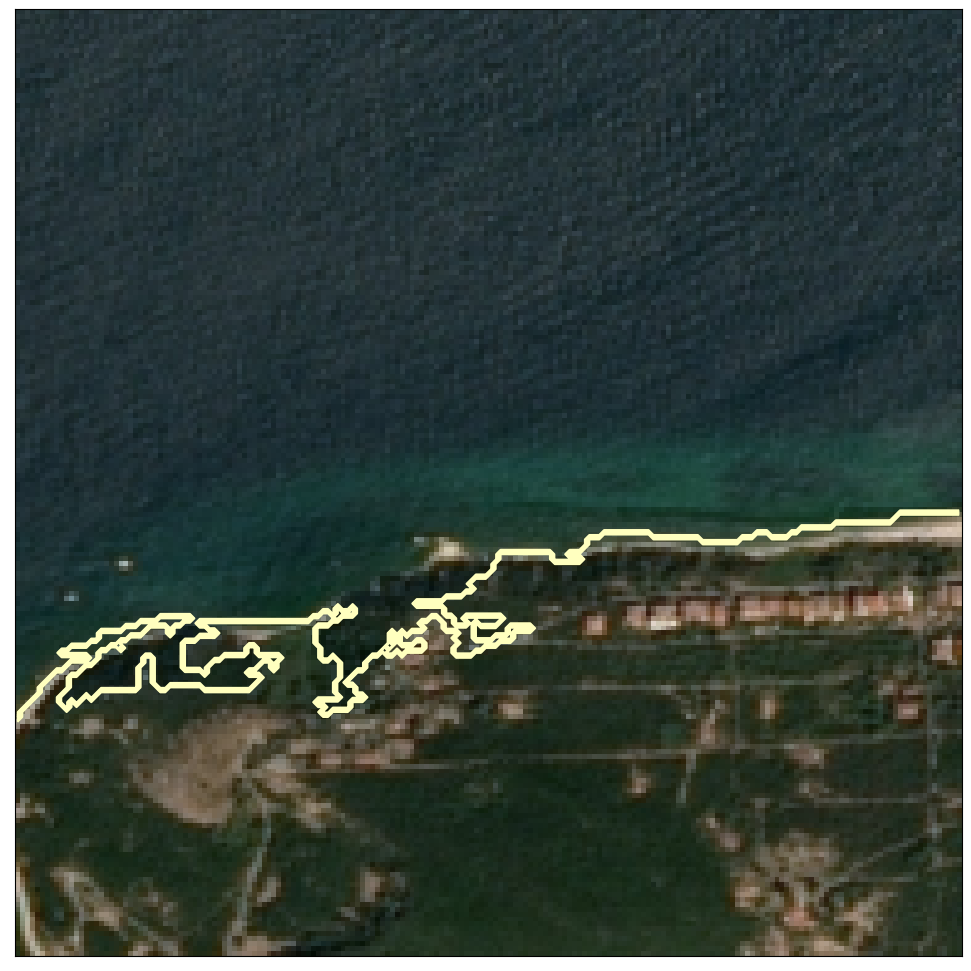

___________________________
image: 17


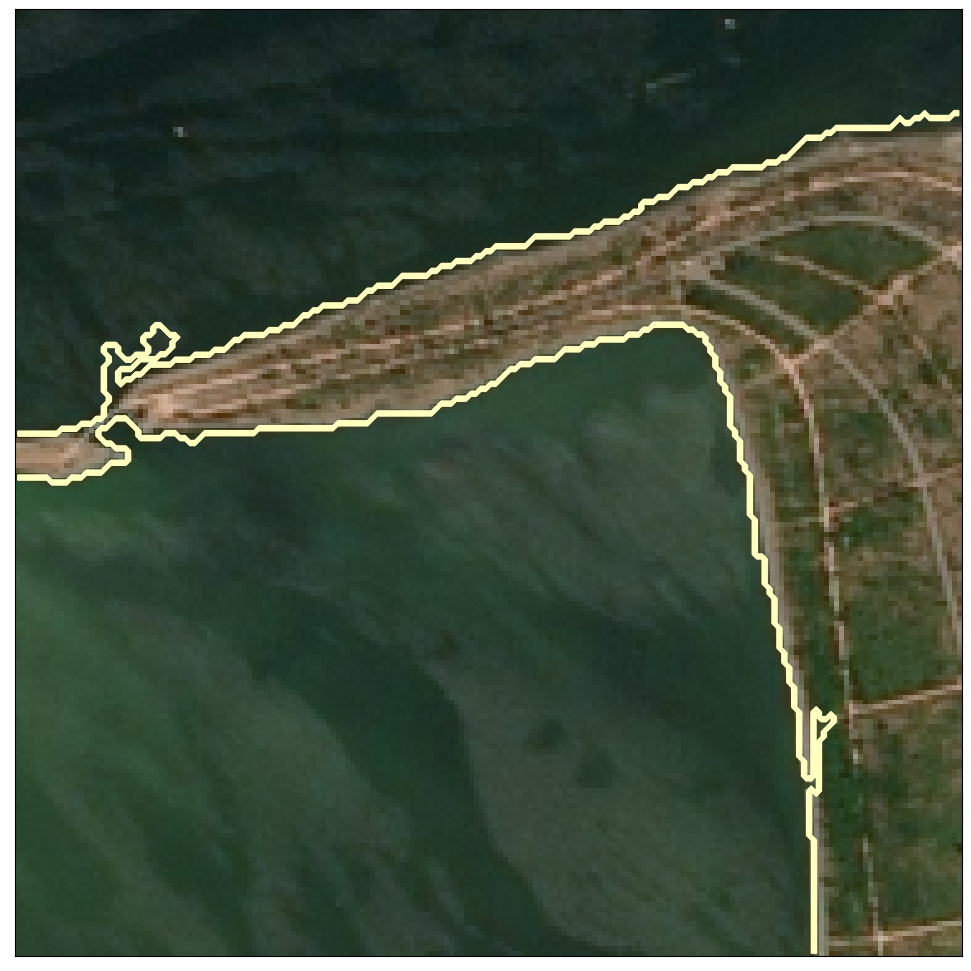

___________________________
image: 21


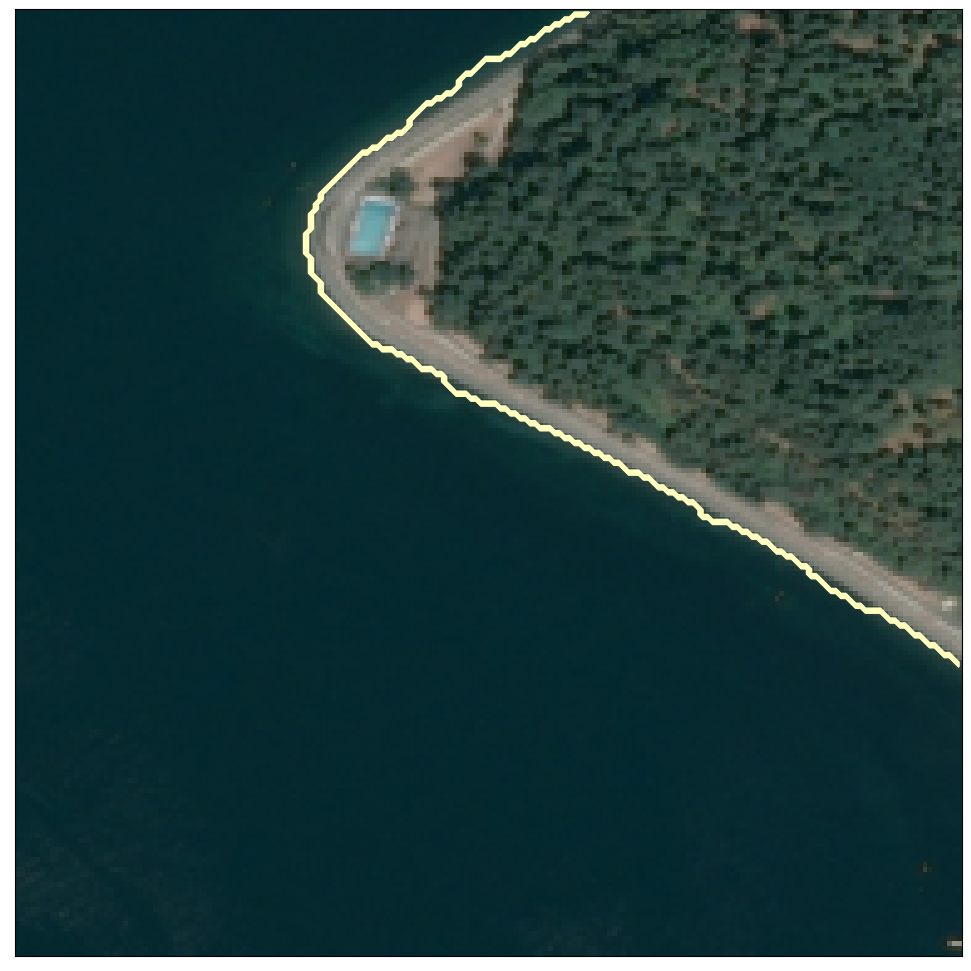

___________________________
image: 28


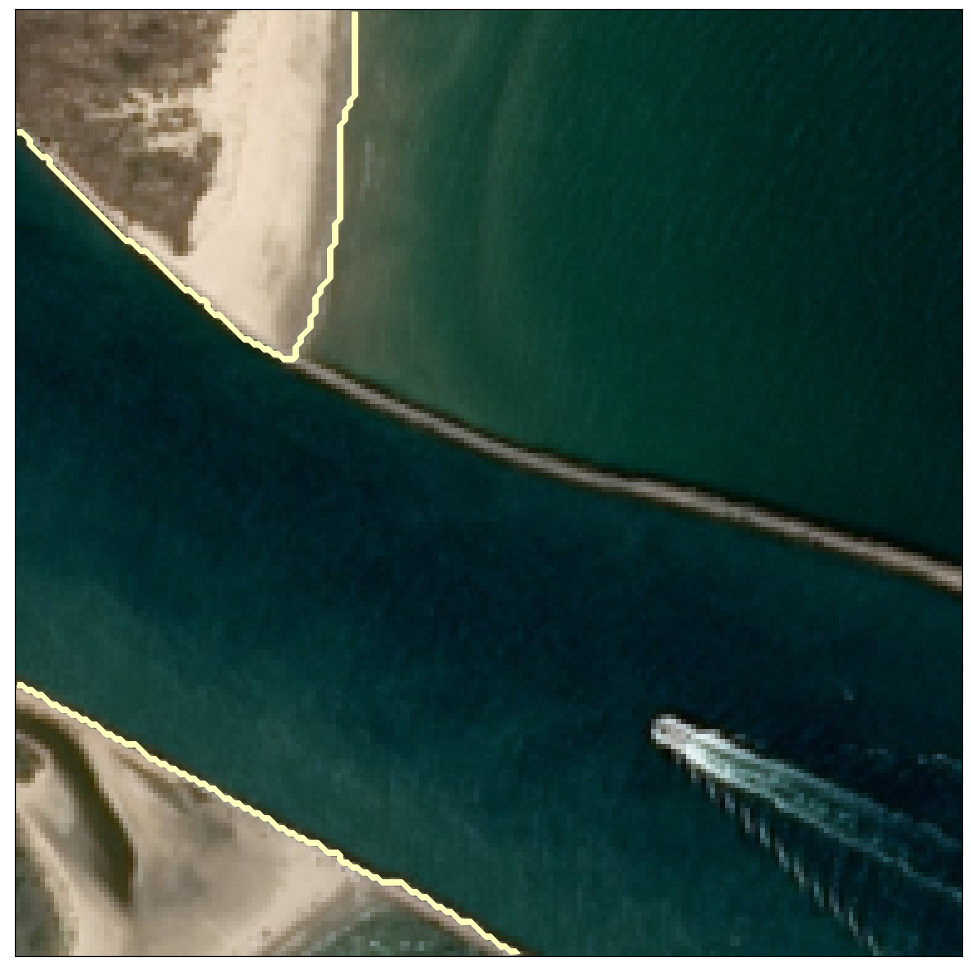

___________________________
image: 30


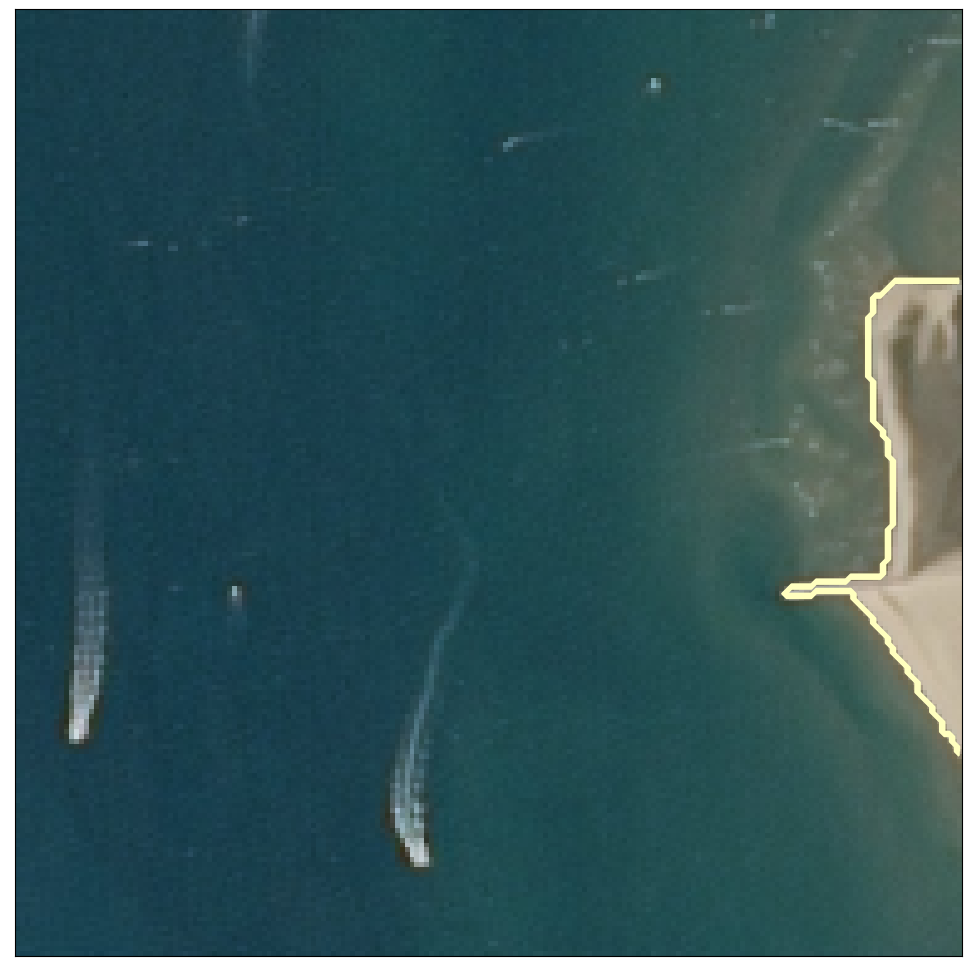

___________________________
image: 33


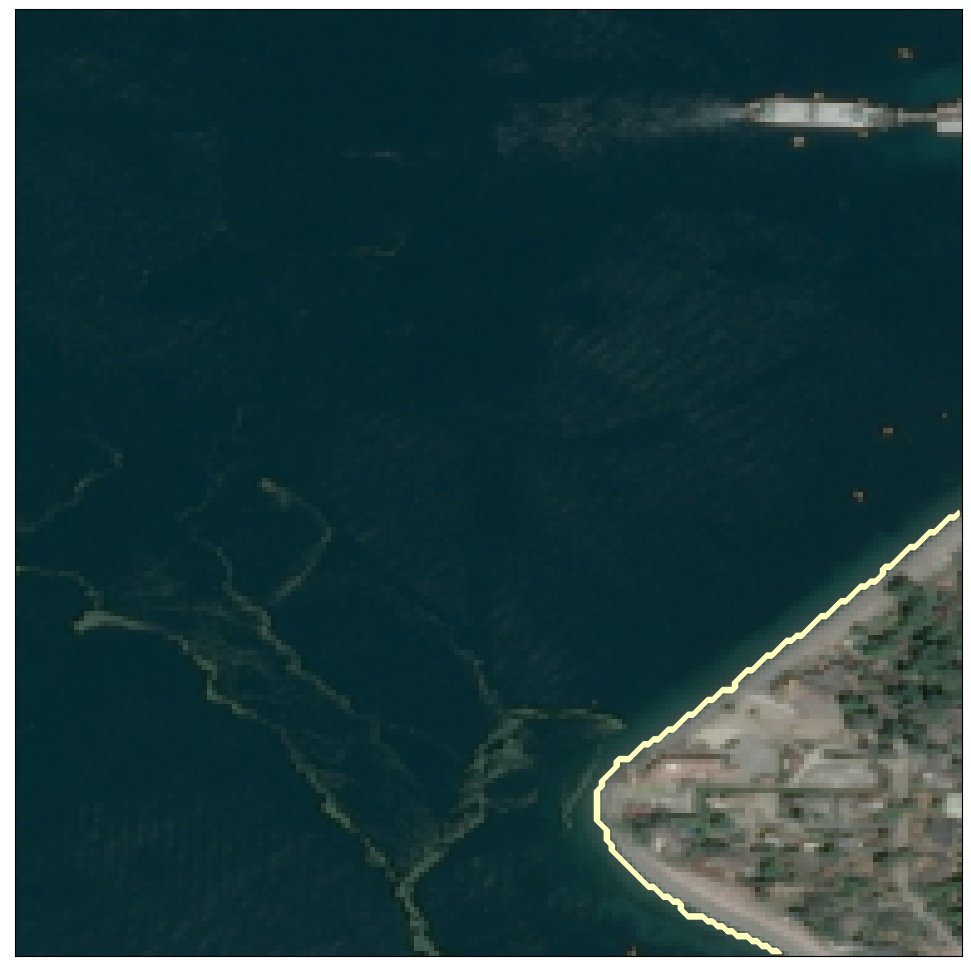

In [16]:
params = {'n_clusters': 50,
          'min_threshold': 53, 
         }
clusters(images[9], Parameters(params), counter=9) 


params = {'n_clusters': 28,
          'min_threshold': 80,
          'min_threshold2': 80,
          'min_island_size': 900
         }
clusters(images[12], Parameters(params), counter=12) 


params = {'n_clusters': 70,
          'min_threshold': 70,
          'min_threshold2': 70,
         }
clusters(images[16], Parameters(params), counter=16) 


params = {'n_clusters': 80,
          'min_threshold': 50,
         }
clusters(images[17], Parameters(params), counter=17) 


params = {'min_threshold': 80,
          'min_threshold2': 80,
         }
clusters(images[21], Parameters(params), counter=21) 


params = {'n_clusters': 30,
          'min_threshold': 20,
         }
clusters(images[28], Parameters(params), counter=28) 
clusters(images[30], Parameters(params), counter=30) 

params = {'n_clusters': 11,
          'min_threshold': 70,
          'min_island_size': 900
         }
clusters(images[33], Parameters(params), counter=33) 

### Ну и еще удалил корабль с 26й картинки

___________________________
image: 26


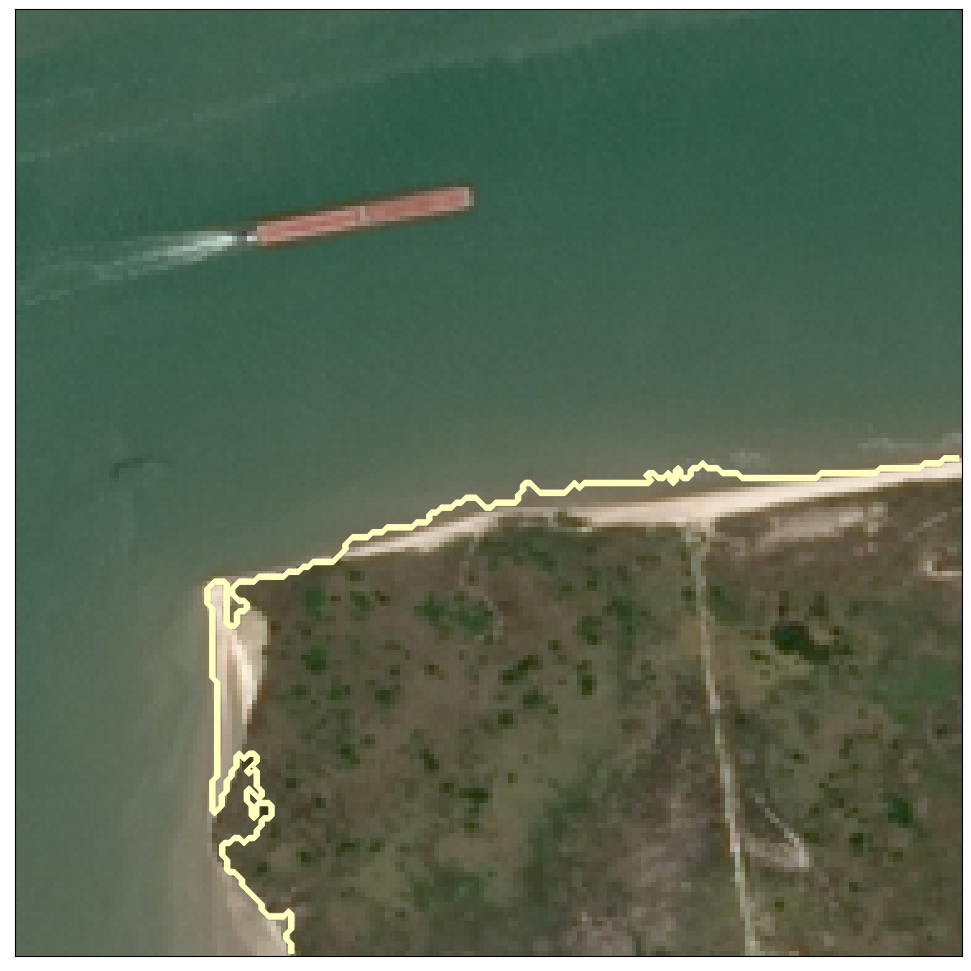

In [17]:
params = {'min_island_size': 900}
clusters(images[26], Parameters(params), counter=26) 

## Проблемы:
0) Долго
1) Кластеры могут не правильно выделяться, в одном кластере могет быть как море, так и суша
2) Море может по цвету быть по цвету как лес (на разных картинках)
3) На одной картинке море может отличаться по цвету от другого моря сильнее, чем от леса (имеются ввиду кластеры)
4) Сложно отличить остров от корабля